# **DECODING MODERN FOOTBALL: TACTICS, TALENT AND TRANSFER VALUE**

**Import Libraries**

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import ast
import unicodedata
from math import pi
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

**Utility Functions**

In [8]:
def fillna_by_median_group(df, group_col, target_col):
    df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.median()))
    return df

In [9]:
def normalize_unicode(name):
    if pd.isnull(name) or not isinstance(name, str):
        return ''

    name = unicodedata.normalize('NFKD', name)
    name = name.encode('ascii', 'ignore').decode('utf-8')
    return name.lower()

In [10]:
def convert_to_short_name(full_name):
    if pd.isnull(full_name) or not isinstance(full_name, str):
        return ''

    parts = full_name.strip().split()
    if len(parts) < 2:
        return full_name.lower()

    first_initial = parts[0][0].lower()
    last_name = parts[-1].lower()

    return f"{first_initial}. {last_name}"

In [11]:
def parse_tag_list(tag_str):
    try:
        tag_list = ast.literal_eval(tag_str)
        if isinstance(tag_list, list):
            return [tag.strip().lstrip('#') for tag in tag_list if tag.strip() and tag != '#']
        return []
    except:
        return []

**Import all the CSV files**

In [12]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/DA SCA/🎓 Graduation Project/'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

Mounted at /content/drive


In [13]:
dfs_dict = {}
for f in csv_files:
    df = pd.read_csv(os.path.join(folder_path, f))
    dfs_dict[f] = df

<ipython-input-13-9b278aebeec4>:3: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, f))


In [14]:
for file_name, df in dfs_dict.items():
    var_name = file_name.replace('.csv', '')
    globals()[var_name] = df

## **Data Cleaning and Processing**

### **FIFA 23 complete player dataset**

In [15]:
ff23_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161583 entries, 0 to 161582
Data columns (total 110 columns):
 #    Column                          Dtype  
---   ------                          -----  
 0    player_id                       int64  
 1    player_url                      object 
 2    fifa_version                    int64  
 3    fifa_update                     int64  
 4    fifa_update_date                object 
 5    short_name                      object 
 6    long_name                       object 
 7    player_positions                object 
 8    overall                         int64  
 9    potential                       int64  
 10   value_eur                       float64
 11   wage_eur                        float64
 12   age                             int64  
 13   dob                             object 
 14   height_cm                       int64  
 15   weight_kg                       int64  
 16   league_id                       float64
 17   league_n

In [16]:
ff23_df.head()

,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
0,158023,/player/158023/lionel-messi/150002,15,2,2014-09-18,L. Messi,Lionel Andrés Messi Cuccittini,CF,93,95,...,62+3,62+3,62+3,54+3,45+3,45+3,45+3,54+3,15+3,https://cdn.sofifa.net/players/158/023/15_120.png
1,20801,/player/20801/c-ronaldo-dos-santos-aveiro/150002,15,2,2014-09-18,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"LW, LM",92,92,...,63+3,63+3,63+3,57+3,52+3,52+3,52+3,57+3,16+3,https://cdn.sofifa.net/players/020/801/15_120.png
2,9014,/player/9014/arjen-robben/150002,15,2,2014-09-18,A. Robben,Arjen Robben,"RM, LM, RW",90,90,...,64+3,64+3,64+3,55+3,46+3,46+3,46+3,55+3,14+3,https://cdn.sofifa.net/players/009/014/15_120.png
3,41236,/player/41236/zlatan-ibrahimovic/150002,15,2,2014-09-18,Z. Ibrahimović,Zlatan Ibrahimović,ST,90,90,...,65+3,65+3,61+3,56+3,55+3,55+3,55+3,56+3,17+3,https://cdn.sofifa.net/players/041/236/15_120.png
4,167495,/player/167495/manuel-neuer/150002,15,2,2014-09-18,M. Neuer,Manuel Peter Neuer,GK,90,90,...,40+3,40+3,36+3,36+3,38+3,38+3,38+3,36+3,87+3,https://cdn.sofifa.net/players/167/495/15_120.png


In [17]:
# Remove unnessary columns
drop_cols = [
    'player_url', 'fifa_update', 'fifa_update_date', 'player_face_url',
    'club_jersey_number', 'nation_jersey_number', 'real_face',
    'club_team_id', 'club_loaned_from', 'club_joined_date', 'club_contract_valid_until_year',
    'league_id', 'league_name', 'league_level', 'release_clause_eur', 'club_position',
    'nationality_id', 'nation_team_id', 'nation_position', 'goalkeeping_speed',
    'ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm',
    'lwb','ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb','gk'
]
ff23_df = ff23_df.drop(columns=drop_cols)

In [18]:
ff23_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161583 entries, 0 to 161582
Data columns (total 63 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   player_id                    161583 non-null  int64  
 1   fifa_version                 161583 non-null  int64  
 2   short_name                   161583 non-null  object 
 3   long_name                    161583 non-null  object 
 4   player_positions             161583 non-null  object 
 5   overall                      161583 non-null  int64  
 6   potential                    161583 non-null  int64  
 7   value_eur                    159530 non-null  float64
 8   wage_eur                     159822 non-null  float64
 9   age                          161583 non-null  int64  
 10  dob                          161583 non-null  object 
 11  height_cm                    161583 non-null  int64  
 12  weight_kg                    161583 non-null  int64  
 13 

In [19]:
# Check data consistency
ff23_df['fifa_version'].unique()

array([15, 16, 17, 18, 19, 20, 21, 22, 23])

In [20]:
ff23_df['player_positions'].unique()

array(['CF', 'LW, LM', 'RM, LM, RW', ..., 'CB, LWB, CDM', 'CM, RW, RB',
       'CM, CAM, LWB'], dtype=object)

In [21]:
ff23_df['short_name'].unique()

array(['L. Messi', 'Cristiano Ronaldo', 'A. Robben', ..., 'Wu Junjie',
       'K. Barlow', 'G. Tetteh'], dtype=object)

In [22]:
ff23_df['club_name'].unique()

array(['FC Barcelona', 'Real Madrid CF', 'FC Bayern München', ..., 'Jerv',
       'Shelbourne', 'UCD'], dtype=object)

In [23]:
ff23_df['nationality_name'].unique()

array(['Argentina', 'Portugal', 'Netherlands', 'Sweden', 'Germany',
       'Spain', 'Uruguay', 'France', 'Colombia', 'Belgium', 'Brazil',
       'Wales', 'Croatia', 'Poland', "Côte d'Ivoire", 'England',
       'Czech Republic', 'Chile', 'Italy', 'Turkey', 'Morocco', 'Serbia',
       'Russia', 'Peru', 'Slovenia', 'Bosnia and Herzegovina', 'Japan',
       'United States', 'Mexico', 'Slovakia', 'Greece', 'Denmark',
       'Austria', 'Venezuela', 'Cameroon', 'Bulgaria', 'Montenegro',
       'Algeria', 'Armenia', 'Togo', 'Switzerland', 'Nigeria', 'Ecuador',
       'Ghana', 'Senegal', 'Paraguay', 'Republic of Ireland',
       'South Africa', 'Finland', 'Northern Ireland', 'Hungary', 'Gabon',
       'Costa Rica', 'Tunisia', 'Canada', 'Korea Republic',
       'North Macedonia', 'Ukraine', 'Mali', 'Congo', 'Albania', 'Benin',
       'Romania', 'Iceland', 'Guinea', 'Australia', 'Scotland',
       'Congo DR', 'Norway', 'Cuba', 'Saudi Arabia', 'Israel', 'Egypt',
       'Lithuania', 'Iran', 'New Ze

In [24]:
ff23_df['preferred_foot'].unique()

array(['Left', 'Right'], dtype=object)

In [25]:
ff23_df['work_rate'].unique()

array(['Medium/Low', 'High/Low', 'Medium/Medium', 'High/Medium',
       'High/High', 'Medium/High', 'Low/Medium', 'Low/High', 'Low/Low'],
      dtype=object)

In [26]:
ff23_df['body_type'].unique()

array(['Normal (170-)', 'Normal (185+)', 'Normal (170-185)',
       'Lean (170-185)', 'Lean (185+)', 'Stocky (170-185)',
       'Stocky (170-)', 'Stocky (185+)', 'Lean (170-)', 'Unique'],
      dtype=object)

In [27]:
ff23_df['overall'].unique()

array([93, 92, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76,
       75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59,
       58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42,
       41, 40, 94, 91])

In [28]:
ff23_df.columns

Index(['player_id', 'fifa_version', 'short_name', 'long_name',
       'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur',
       'age', 'dob', 'height_cm', 'weight_kg', 'club_name', 'nationality_name',
       'preferred_foot', 'weak_foot', 'skill_moves',
       'international_reputation', 'work_rate', 'body_type', 'player_tags',
       'player_traits', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positionin

In [29]:
# Covert data type
ff23_df[['fifa_version', 'preferred_foot', 'work_rate', 'body_type']] = ff23_df[['fifa_version', 'preferred_foot', 'work_rate', 'body_type']].astype('category')
ff23_df[['short_name', 'long_name', 'player_positions', 'club_name', 'nationality_name']] \
       = ff23_df[['short_name', 'long_name', 'player_positions', 'club_name', 'nationality_name']].astype(str)

In [30]:
# Covert data type
convert_cols = [
       'value_eur', 'wage_eur',
       'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes'
]
ff23_df[convert_cols] = ff23_df[convert_cols].astype('float64')

In [31]:
ff23_df['dob'].unique()

array(['1987-06-24', '1985-02-05', '1984-01-23', ..., '2005-08-21',
       '2005-09-15', '2005-05-20'], dtype=object)

In [32]:
ff23_df['dob'] = pd.to_datetime(ff23_df['dob'], errors='coerce')
ff23_df.rename(columns={'dob': 'date_of_birth'}, inplace=True)

In [33]:
ff23_df = ff23_df.drop_duplicates(keep = 'first', ignore_index = True)

In [34]:
ff23_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161583 entries, 0 to 161582
Data columns (total 63 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   player_id                    161583 non-null  int64         
 1   fifa_version                 161583 non-null  category      
 2   short_name                   161583 non-null  object        
 3   long_name                    161583 non-null  object        
 4   player_positions             161583 non-null  object        
 5   overall                      161583 non-null  int64         
 6   potential                    161583 non-null  int64         
 7   value_eur                    159530 non-null  float64       
 8   wage_eur                     159822 non-null  float64       
 9   age                          161583 non-null  int64         
 10  date_of_birth                161583 non-null  datetime64[ns]
 11  height_cm                 

In [35]:
ff23_df.head()

,player_id,fifa_version,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,158023,15,L. Messi,Lionel Andrés Messi Cuccittini,CF,93,95,100500000.0,550000.0,27,...,76.0,NaN,25.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0
1,20801,15,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"LW, LM",92,92,79000000.0,375000.0,29,...,85.0,NaN,22.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,9014,15,A. Robben,Arjen Robben,"RM, LM, RW",90,90,54500000.0,275000.0,30,...,80.0,NaN,29.0,26.0,26.0,10.0,8.0,11.0,5.0,15.0
3,41236,15,Z. Ibrahimović,Zlatan Ibrahimović,ST,90,90,52500000.0,275000.0,32,...,91.0,NaN,25.0,41.0,27.0,13.0,15.0,10.0,9.0,12.0
4,167495,15,M. Neuer,Manuel Peter Neuer,GK,90,90,63500000.0,300000.0,28,...,37.0,NaN,25.0,25.0,25.0,87.0,85.0,92.0,90.0,86.0


### **Football Data from Transfermarkt**

In [36]:
tm_players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32601 entries, 0 to 32600
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   player_id                             32601 non-null  int64  
 1   first_name                            30539 non-null  object 
 2   last_name                             32601 non-null  object 
 3   name                                  32601 non-null  object 
 4   last_season                           32601 non-null  int64  
 5   current_club_id                       32601 non-null  int64  
 6   player_code                           32601 non-null  object 
 7   country_of_birth                      29802 non-null  object 
 8   city_of_birth                         30146 non-null  object 
 9   country_of_citizenship                32218 non-null  object 
 10  date_of_birth                         32554 non-null  object 
 11  sub_position   

In [37]:
tm_players_df.head()

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,...,right,184.0,NaN,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,...,left,190.0,NaN,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,750000.0,8000000.0
2,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,...,NaN,NaN,NaN,CSKA-AS-23 Ltd.,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/dimitar-berbat...,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0
3,77,NaN,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,...,NaN,NaN,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lucio/profil/s...,IT1,Juventus Football Club,200000.0,24500000.0
4,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,...,right,194.0,NaN,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tom-starke/pro...,L1,FC Bayern München,100000.0,3000000.0


In [38]:
tm_players_df = tm_players_df.convert_dtypes()

In [39]:
tm_players_df['date_of_birth'].unique()

<StringArray>
['1978-06-09 00:00:00', '1980-08-06 00:00:00', '1981-01-30 00:00:00',
 '1978-05-08 00:00:00', '1981-03-18 00:00:00', '1978-04-18 00:00:00',
 '1980-11-05 00:00:00', '1980-10-04 00:00:00', '1976-06-13 00:00:00',
 '1981-08-16 00:00:00',
 ...
 '2006-11-16 00:00:00', '2008-03-26 00:00:00', '2009-09-08 00:00:00',
 '2006-06-12 00:00:00', '2006-11-14 00:00:00', '2007-09-21 00:00:00',
 '2005-10-23 00:00:00', '2009-02-25 00:00:00', '2006-12-12 00:00:00',
 '2006-09-19 00:00:00']
Length: 9307, dtype: string

In [40]:
tm_players_df['date_of_birth'] = pd.to_datetime(tm_players_df['date_of_birth'], errors='coerce')
tm_players_df['date_of_birth'].dt.strftime('%Y-%m-%d')

,date_of_birth
0,1978-06-09
1,1980-08-06
2,1981-01-30
3,1978-05-08
4,1981-03-18
...,...
32596,2003-08-23
32597,2006-09-19
32598,2007-02-19
32599,2007-01-02


In [41]:
tm_players_df['country_of_citizenship'].unique()

<StringArray>
[          'Germany',          'Bulgaria',            'Brazil',
    'Czech Republic',          'Paraguay',           'Hungary',
           'Denmark',           'Georgia',   'North Macedonia',
              'Peru',
 ...
           'Bonaire', 'Brunei Darussalam',        'San Marino',
           'Vietnam',      'Korea, North',      'Sint Maarten',
           'Bahrain',           'Andorra',         'Singapore',
    'Southern Sudan']
Length: 184, dtype: string

In [42]:
# Rename columns to get join key
tm_players_df.rename(columns={'country_of_citizenship': 'nationality_name'}, inplace=True)

In [43]:
tm_players_df['position'].unique()

<StringArray>
['Attack', 'Goalkeeper', 'Defender', 'Midfield', 'Missing']
Length: 5, dtype: string

In [44]:
tm_players_df['position'].value_counts(normalize=True)

,proportion
position,
Defender,0.318671
Midfield,0.288059
Attack,0.273642
Goalkeeper,0.114107
Missing,0.005521


Since the number of 'Missing' values ​​in the column position of the tm_players_df dataset only uses 0.6%, we will drop these values.

In [45]:
tm_players_df = tm_players_df[tm_players_df['position'] != 'Missing']

In [46]:
tm_players_df = tm_players_df.drop_duplicates(keep='first', ignore_index=True)

In [47]:
tm_players_df.head()

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,nationality_name,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,...,right,184,<NA>,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,1000000,30000000
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,...,left,190,<NA>,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,750000,8000000
2,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,...,<NA>,<NA>,<NA>,CSKA-AS-23 Ltd.,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/dimitar-berbat...,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000,34500000
3,77,<NA>,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,...,<NA>,<NA>,<NA>,<NA>,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lucio/profil/s...,IT1,Juventus Football Club,200000,24500000
4,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,...,right,194,<NA>,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tom-starke/pro...,L1,FC Bayern München,100000,3000000


In [48]:
# Normalize the 'name' column in both datasets
ff23_df['name'] = ff23_df['short_name'].apply(convert_to_short_name).apply(normalize_unicode)
tm_players_df['name'] = tm_players_df['name'].apply(convert_to_short_name).apply(normalize_unicode)

In [49]:
# Create a standardized join key
ff23_df['join_key'] = (
    ff23_df['name'].str.lower().str.replace('.', '', regex=False).str.strip() + '|' +
    ff23_df['date_of_birth'].astype(str) + '|' +
    ff23_df['nationality_name'].str.lower().str.strip()
)

tm_players_df['join_key'] = (
    tm_players_df['name'].str.lower().str.replace('.', '', regex=False).str.strip() + '|' +
    tm_players_df['date_of_birth'].astype(str) + '|' +
    tm_players_df['nationality_name'].str.lower().str.strip()
)

# Drop duplicates join_key
tm_players_df.drop_duplicates(subset='join_key', keep='first', inplace=True)

# Join
ff23_df = ff23_df.merge(tm_players_df[['join_key', 'position']], on='join_key', how='left')

In [50]:
# Mapping Transfermarkt position
position_map = {
    'Goalkeeper': 'GK',
    'Defender': 'DF',
    'Midfield': 'MF',
    'Attack': 'FW'
}
ff23_df['position_group'] = ff23_df['position'].map(position_map)

In [51]:
ff23_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161583 entries, 0 to 161582
Data columns (total 67 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   player_id                    161583 non-null  int64         
 1   fifa_version                 161583 non-null  category      
 2   short_name                   161583 non-null  object        
 3   long_name                    161583 non-null  object        
 4   player_positions             161583 non-null  object        
 5   overall                      161583 non-null  int64         
 6   potential                    161583 non-null  int64         
 7   value_eur                    159530 non-null  float64       
 8   wage_eur                     159822 non-null  float64       
 9   age                          161583 non-null  int64         
 10  date_of_birth                161583 non-null  datetime64[ns]
 11  height_cm                 

In [52]:
ff23_df.head()

,player_id,fifa_version,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,name,join_key,position,position_group
0,158023,15,L. Messi,Lionel Andrés Messi Cuccittini,CF,93,95,100500000.0,550000.0,27,...,20.0,6.0,11.0,15.0,14.0,8.0,l. messi,l messi|1987-06-24|argentina,Attack,FW
1,20801,15,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"LW, LM",92,92,79000000.0,375000.0,29,...,23.0,7.0,11.0,15.0,14.0,11.0,c. ronaldo,c ronaldo|1985-02-05|portugal,Attack,FW
2,9014,15,A. Robben,Arjen Robben,"RM, LM, RW",90,90,54500000.0,275000.0,30,...,26.0,10.0,8.0,11.0,5.0,15.0,a. robben,a robben|1984-01-23|netherlands,Attack,FW
3,41236,15,Z. Ibrahimović,Zlatan Ibrahimović,ST,90,90,52500000.0,275000.0,32,...,27.0,13.0,15.0,10.0,9.0,12.0,z. ibrahimovic,z ibrahimovic|1981-10-03|sweden,Attack,FW
4,167495,15,M. Neuer,Manuel Peter Neuer,GK,90,90,63500000.0,300000.0,28,...,25.0,87.0,85.0,92.0,90.0,86.0,m. neuer,m neuer|1986-03-27|germany,Goalkeeper,GK


In [53]:
# Fill N/A numeric columns by median in each position_group
numeric_cols = ff23_df.select_dtypes('float64').columns.tolist()
for col in numeric_cols:
    ff23_df = fillna_by_median_group(ff23_df, 'position_group', col)

In [54]:
# Drop N/A values and reset index
cols_needed = ff23_df.columns[ff23_df.notna().sum() == 68830].tolist()
ff23_df.dropna(subset=cols_needed, inplace=True)
ff23_df.reset_index(drop=True, inplace=True)

In [55]:
ff23_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68830 entries, 0 to 68829
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   player_id                    68830 non-null  int64         
 1   fifa_version                 68830 non-null  category      
 2   short_name                   68830 non-null  object        
 3   long_name                    68830 non-null  object        
 4   player_positions             68830 non-null  object        
 5   overall                      68830 non-null  int64         
 6   potential                    68830 non-null  int64         
 7   value_eur                    68830 non-null  float64       
 8   wage_eur                     68830 non-null  float64       
 9   age                          68830 non-null  int64         
 10  date_of_birth                68830 non-null  datetime64[ns]
 11  height_cm                    68830 non-nu

In [56]:
tm_player_valuations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496606 entries, 0 to 496605
Data columns (total 5 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   player_id                            496606 non-null  int64 
 1   date                                 496606 non-null  object
 2   market_value_in_eur                  496606 non-null  int64 
 3   current_club_id                      496606 non-null  int64 
 4   player_club_domestic_competition_id  496606 non-null  object
dtypes: int64(3), object(2)
memory usage: 18.9+ MB


In [57]:
tm_player_valuations_df.head()

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
0,405973,2000-01-20,150000,3057,BE1
1,342216,2001-07-20,100000,1241,SC1
2,3132,2003-12-09,400000,126,TR1
3,6893,2003-12-15,900000,984,GB1
4,10,2004-10-04,7000000,398,IT1


In [58]:
tm_players_df = tm_players_df.drop(columns='market_value_in_eur')

In [59]:
tm_player_valuations_df = tm_player_valuations_df.convert_dtypes()

In [60]:
tm_player_valuations_df['market_year'] = pd.to_datetime(tm_player_valuations_df['date']).dt.year

In [61]:
# Convert to year
tm_player_valuations_df['market_year'] = pd.to_datetime(tm_player_valuations_df['date']).dt.year

# Calculate mean per year for per player
tm_player_valuations_df = tm_player_valuations_df.groupby(['player_id', 'market_year'])['market_value_in_eur'].mean().reset_index()

In [62]:
# Merge to include market_year and market_value_in_eur columns into tm_players_df
tm_players_df = tm_players_df.merge(
    tm_player_valuations_df[['player_id', 'market_year', 'market_value_in_eur']],
    on='player_id',
    how='left'
)

In [63]:
tm_players_df = tm_players_df.convert_dtypes()

In [64]:
# Map fifa version with following year to join
fifa_to_year = {
    15: 2015,
    16: 2016,
    17: 2017,
    18: 2018,
    19: 2019,
    20: 2020,
    21: 2021,
    22: 2022,
    23: 2023,
}
ff23_df['market_year'] = ff23_df['fifa_version'].map(fifa_to_year).astype(pd.Int64Dtype())

In [65]:
ff23_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68830 entries, 0 to 68829
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   player_id                    68830 non-null  int64         
 1   fifa_version                 68830 non-null  category      
 2   short_name                   68830 non-null  object        
 3   long_name                    68830 non-null  object        
 4   player_positions             68830 non-null  object        
 5   overall                      68830 non-null  int64         
 6   potential                    68830 non-null  int64         
 7   value_eur                    68830 non-null  float64       
 8   wage_eur                     68830 non-null  float64       
 9   age                          68830 non-null  int64         
 10  date_of_birth                68830 non-null  datetime64[ns]
 11  height_cm                    68830 non-nu

In [66]:
# Merge final
ff23_df = ff23_df.merge(
    tm_players_df[['join_key', 'market_year', 'market_value_in_eur']],
    on=['join_key', 'market_year'],
    how='left'
)

In [67]:
ff23_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68830 entries, 0 to 68829
Data columns (total 69 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   player_id                    68830 non-null  int64         
 1   fifa_version                 68830 non-null  category      
 2   short_name                   68830 non-null  object        
 3   long_name                    68830 non-null  object        
 4   player_positions             68830 non-null  object        
 5   overall                      68830 non-null  int64         
 6   potential                    68830 non-null  int64         
 7   value_eur                    68830 non-null  float64       
 8   wage_eur                     68830 non-null  float64       
 9   age                          68830 non-null  int64         
 10  date_of_birth                68830 non-null  datetime64[ns]
 11  height_cm                    68830 non-nu

## **Exploratory Data Analysis**

In [68]:
# Dataset overview
print("🔍 Dataset Overview:")
print(ff23_df.shape)
print(ff23_df.info())
print("\n🧼 Missing Values:")
print(ff23_df.isna().sum() > 0)

🔍 Dataset Overview:
(68830, 69)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68830 entries, 0 to 68829
Data columns (total 69 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   player_id                    68830 non-null  int64         
 1   fifa_version                 68830 non-null  category      
 2   short_name                   68830 non-null  object        
 3   long_name                    68830 non-null  object        
 4   player_positions             68830 non-null  object        
 5   overall                      68830 non-null  int64         
 6   potential                    68830 non-null  int64         
 7   value_eur                    68830 non-null  float64       
 8   wage_eur                     68830 non-null  float64       
 9   age                          68830 non-null  int64         
 10  date_of_birth                68830 non-null  datetime64[ns]
 11  height_cm

- Here we don't need to fillna for the market_value_in_eur column because it is **the actual market value of Transfermarkt**, we need real data to evaluate underrated/overrated for part 3.
- 5% missing is **acceptable**, we can filter out these rows when doing the final evaluation after building the model.

In [69]:
ff23_df.describe(include='all')

,player_id,fifa_version,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,name,join_key,position,position_group,market_year,market_value_in_eur
count,68830.000000,68830.0,68830,68830,68830,68830.000000,68830.000000,6.883000e+04,68830.000000,68830.000000,...,68830.000000,68830.000000,68830.000000,68830.000000,68830,68830,68830,68830,68830.0,65238.0
unique,NaN,9.0,16845,17443,1324,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,16140,17208,4,4,<NA>,<NA>
top,NaN,23.0,Paulinho,Danny Ward,CB,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,paulinho,j murphy|1995-02-24|england,Defender,DF,<NA>,<NA>
freq,NaN,8017.0,41,18,8773,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,41,18,22521,22521,<NA>,<NA>
mean,208749.040593,NaN,NaN,NaN,NaN,68.548322,73.488275,3.798949e+06,17088.559494,25.182203,...,16.512219,16.338428,16.570231,16.933445,NaN,NaN,NaN,NaN,2019.127241,3597449.10394
min,2.000000,NaN,NaN,NaN,NaN,44.000000,49.000000,1.000000e+03,500.000000,16.000000,...,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,2015.0,10000.0
25%,192587.000000,NaN,NaN,NaN,NaN,64.000000,69.000000,5.750000e+05,3000.000000,22.000000,...,8.000000,8.000000,8.000000,8.000000,NaN,NaN,NaN,NaN,2017.0,375000.0
50%,212483.000000,NaN,NaN,NaN,NaN,68.000000,73.000000,1.200000e+06,7000.000000,25.000000,...,11.000000,11.000000,11.000000,11.000000,NaN,NaN,NaN,NaN,2019.0,850000.0
75%,232671.000000,NaN,NaN,NaN,NaN,73.000000,77.000000,3.300000e+06,20000.000000,28.000000,...,14.000000,14.000000,14.000000,14.000000,NaN,NaN,NaN,NaN,2021.0,2700000.0
max,271815.000000,NaN,NaN,NaN,NaN,94.000000,95.000000,1.940000e+08,575000.000000,44.000000,...,92.000000,95.000000,91.000000,94.000000,NaN,NaN,NaN,NaN,2023.0,200000000.0


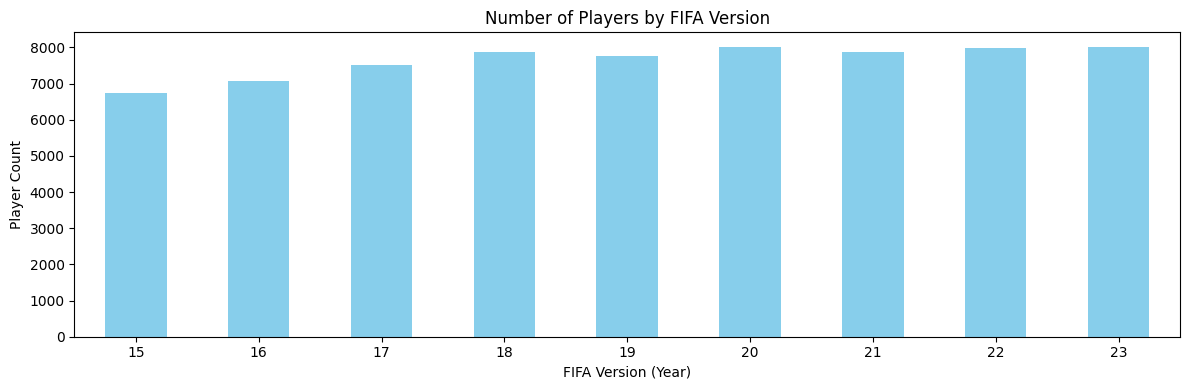

In [70]:
# Distribution by FIFA Version (Year)
plt.figure(figsize=(12,4))
ff23_df['fifa_version'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Players by FIFA Version')
plt.xlabel('FIFA Version (Year)')
plt.ylabel('Player Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The bar chart shows that the number of players with complete attribute data (i.e., no major missing values) is quite consistent across FIFA versions from 2015 to 2023, ranging from approximately **6,800 to over 8,000 players per year.** This indicates that the filtered dataset is **balanced and reliable**, with no specific year being over- or under-represented. Such consistency allows for trustworthy time-series analyses.

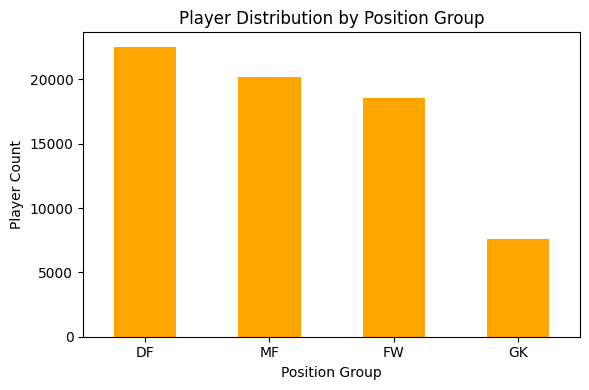

In [71]:
# Distribution by position groups
plt.figure(figsize=(6,4))
ff23_df['position_group'].value_counts().plot(kind='bar', color='orange')
plt.title('Player Distribution by Position Group')
plt.xlabel('Position Group')
plt.ylabel('Player Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The bar chart shows the distribution of players by position group:
- **Defenders (DF)** are the most numerous, with over **22,000 players**, indicating a wide variety of defensive roles represented in the data.
- **Midfielders (MF)** and **Forwards (FW)** have a fairly balanced count (around **18,000–20,000**), offering enough representation for detailed role-based analysis.
- **Goalkeepers (GK)** have the smallest count (around **7,000**), which is expected given that teams typically have fewer goalkeepers.

➡️ Overall, the player distribution is **balanced and sufficient**, allowing for meaningful position-based comparisons in subsequent analyses. In addition, if we look more closely, in a relative way we can see that based on the number of players in each position, the most popular formation used is 4-3-3 (4 defenders - 3 midfielders - 3 forwards), quite interesting, right?

Because overall is averaged by main attributes, and main attributes are averaged by detailed attributes, we only need to EDA by main attributes, then analyze in more detail.

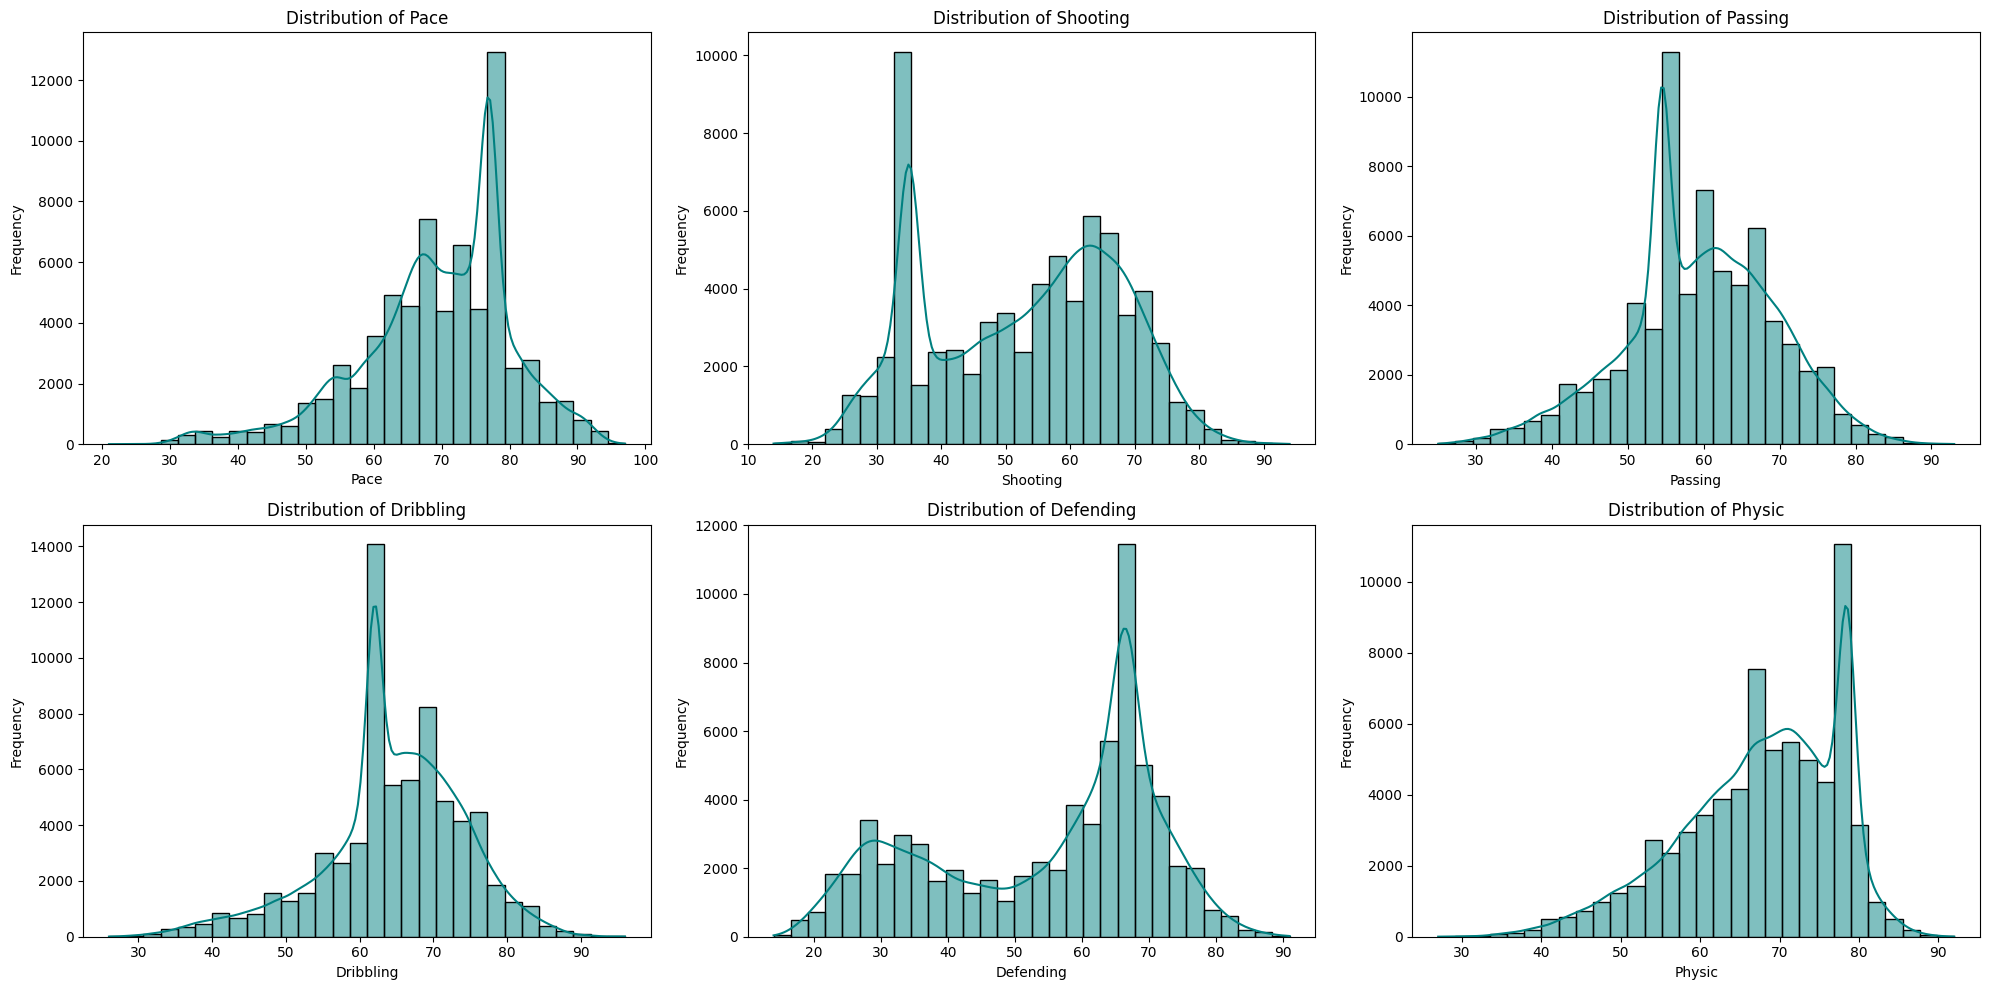

In [72]:
# Distribution of main attributes
main_attributes = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i, attr in enumerate(main_attributes):
    sns.histplot(ff23_df[attr], bins=30, kde=True, color='teal', ax=axes[i])
    axes[i].set_title(f'Distribution of {attr.capitalize()}')
    axes[i].set_xlabel(attr.capitalize())
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Insights:**
- **Pace:** slight right-skewed distribution, with most players having pace between **60–80**, peaking around **75–80**. Very fast players (90+) are rare.
- **Shooting:** highly right-skewed, most players have average shooting in the **30–70** range. Exceptional shooters (80+) are relatively few.
- **Passing:** almost normal distribution centered around **55–65**, indicating a balanced spread. Top-tier passers (above 80) are rare.
- **Dribbling:** concentrated around **60–70** with slight variation on both ends, reflecting consistent dribbling ability across player groups.
- **Defending:** bimodal shape, one peak at **30–40** (attackers, midfielders) and another at **60–70** (defensive roles), reflecting a clear divide between attack and defense.
- **Physic:** widely distributed with most values in the **60–80** range, peaking at **75–80**, showing physicality is a generally well-represented attribute.

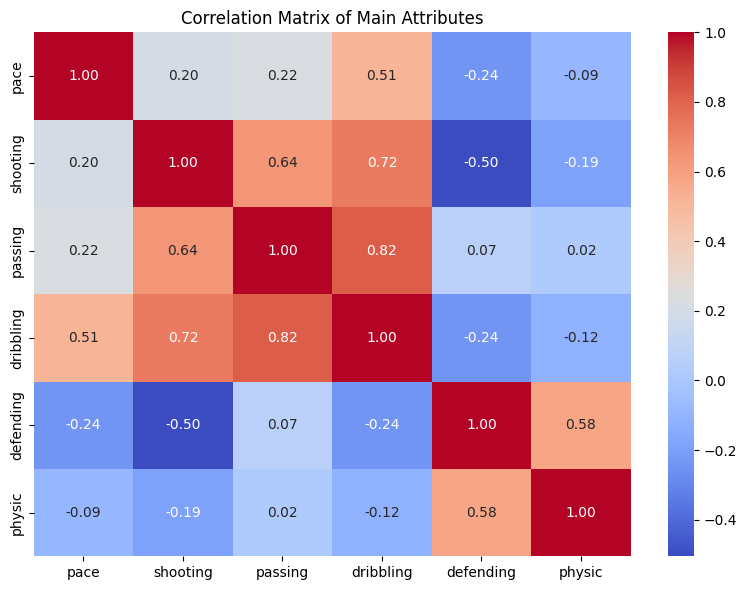

In [73]:
# Correlation matrix of Main Attributes
plt.figure(figsize=(8,6))
sns.heatmap(ff23_df[main_attributes].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Main Attributes')
plt.tight_layout()
plt.show()

**Insights:**

**🔍 Strong Correlations:**
- **Passing – Dribbling:** 0.82 → Players who are good passers often excel at dribbling. This makes sense for playmakers (CAM, CM).
- **Shooting – Dribbling:** 0.72 → Players who shoot well also tend to dribble well — commonly seen in technical forwards (ST, CF, wingers like Messi, Neymar, Mbappé).
- **Shooting – Passing:** 0.64 → Players with good shooting ability often have decent passing skills — typical for all-rounded attacking midfielders (Kevin De Bruyne).

**📉 Strong Negative Correlations:**
- **Shooting – Defending:** -0.50 → Attacking players (good shooters) usually aren't strong defenders — clearly reflecting the difference between strikers and defenders.
- **Dribbling – Defending:** -0.24 → Players good at dribbling tend to be weaker at defending — common for offensive roles.

**📌 Other Notable Relationships:**
- **Pace – Dribbling:** 0.51 → Fast players often dribble well — usually wide players and wingers.
- **Defending – Physic:** 0.58 → Defenders and defensive midfielders usually possess strong physical attributes (CB, CDM).
- **Pace – Defending:** -0.24 → Good defenders aren't necessarily fast (with exceptions like modern fullbacks: Walker, Hakimi, etc).

**🧠 Insight Summary:** Players can generally be grouped into two major clusters:
- **Technical – Attacking Group:** Dribbling, Passing, Shooting, Pace (strong positive correlation within).
- **Physical – Defensive Group:** Defending, Physic (positive correlation within, negatively correlated with technical attributes).

This correlation heatmap is useful for clustering player roles or building classification models based on player positions.

<ipython-input-74-55bb9f98e82e>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_grouped.groupby(['fifa_version', 'position_group'])[main_attributes].mean().reset_index()


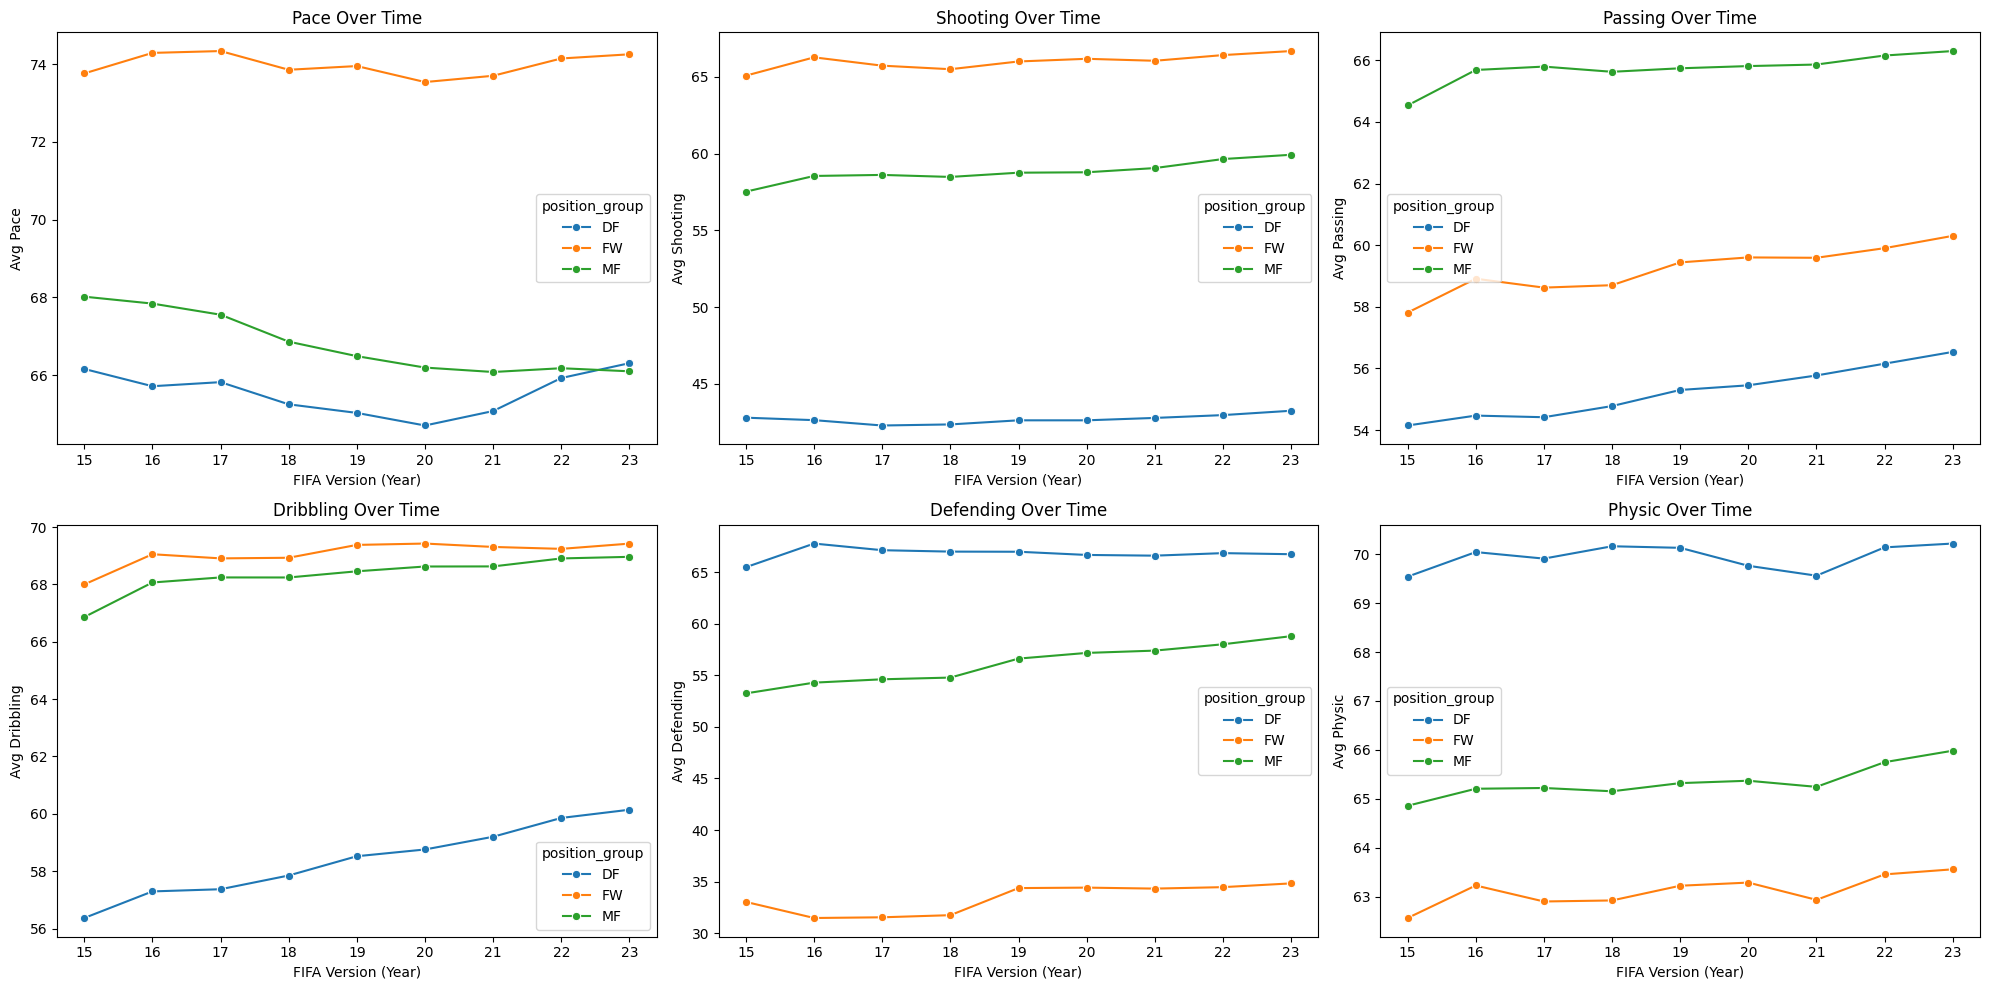

In [74]:
# Mean of main attributes by year and position group
df_grouped = ff23_df[ff23_df['position_group'] != 'GK']
df_grouped = df_grouped.groupby(['fifa_version', 'position_group'])[main_attributes].mean().reset_index()

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i, attr in enumerate(main_attributes):
    sns.lineplot(data=df_grouped, x='fifa_version', y=attr, hue='position_group',
                 marker='o', ax=axes[i])
    axes[i].set_title(f'{attr.capitalize()} Over Time')
    axes[i].set_xlabel('FIFA Version (Year)')
    axes[i].set_ylabel(f'Avg {attr.capitalize()}')
    axes[i].tick_params(axis='x', rotation=0)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Insights:**
- **Pace:** The average speed of forwards (FW) and defenders (DF) remains relatively stable over the years, while midfielders (MF) have seen a slight decline.
- **Shooting:** Forwards consistently have the highest shooting statistics with a slight upward trend, midfielders also have a slight upward trend while defenders are almost unchanged
- **Passing:** Midfielders (MF) lead the way in passing and show a steady increase over time. Other positional groups also show slight improvements.
- **Dribbling:** Dribbling remains high and stable for both forwards and midfielders. However, defenders show noticeable improvement over time, reflecting the increasing importance of ball control.
- **Defending:** Defenders maintain high and consistent defensive stats. Midfielders show a gradual increase, showing more all-round responsibility. Forwards also improve slightly despite their low values.
- **Physic:** Midfielders show slight improvement, while defenders and forwards remain largely unchanged.

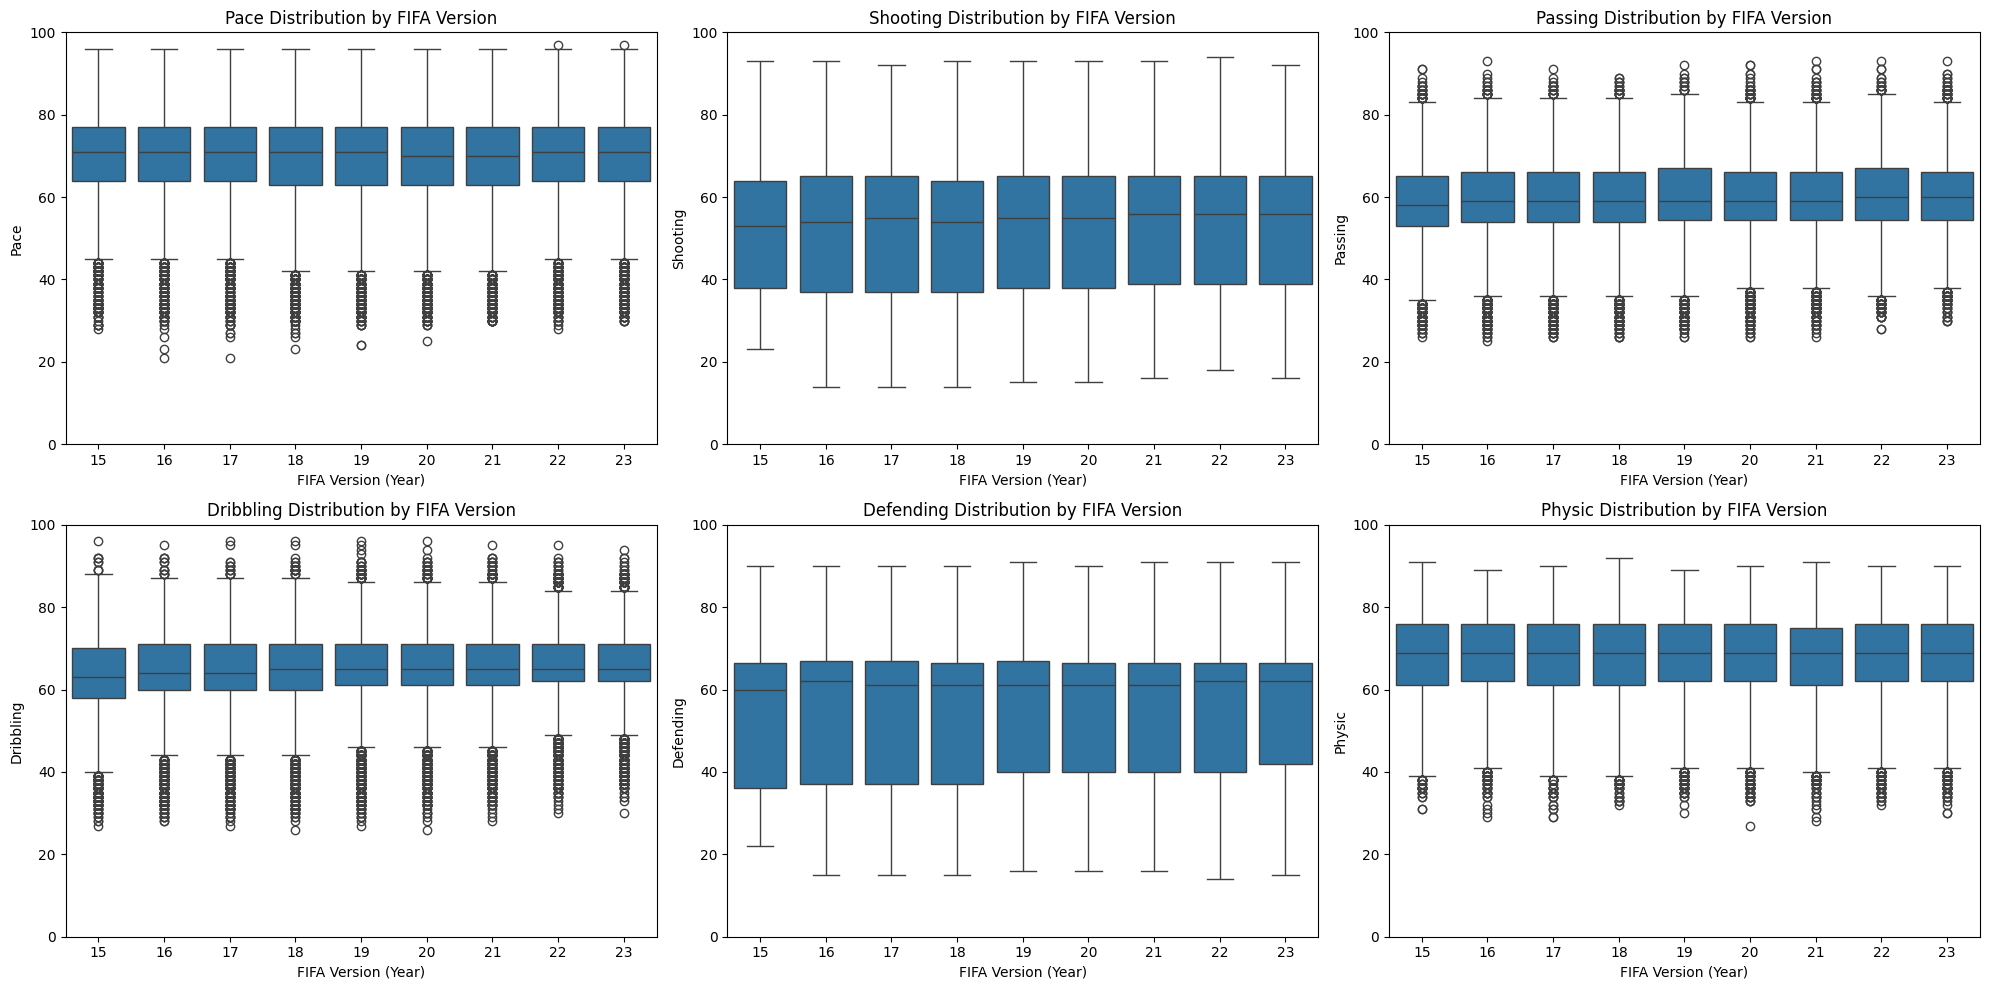

In [75]:
# Boxplot by year to check outliers
plt.figure(figsize=(20, 10))
for idx, attr in enumerate(main_attributes, 1):
    plt.subplot(2, 3, idx)
    sns.boxplot(data=ff23_df, x='fifa_version', y=attr)
    plt.title(f'{attr.capitalize()} Distribution by FIFA Version')
    plt.xlabel('FIFA Version (Year)')
    plt.ylabel(attr.capitalize())
    plt.ylim(0, 100)
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Insights:**
- **Stable distribution:** The Pace, Shooting, Passing, Dribbling, Defending and Physic indicators all have a fairly stable distribution across FIFA versions. The Median and IQR do not change significantly, indicating that the player rating structure is maintained consistently.
- **Outliers:** There are many outliers, mainly players with very low ratings. This reflects the diversity of player quality in the game.
- **Differences between indicators:** Pace, Dribbling and Physic tend to be higher than Passing, Shooting and Defending, which are often concentrated at the average/low level.

→ The EDA results show that the data has a clear structure, is stable over time and has a clear stratification between indicators. We don't need to remove outliers because these are all important data points that support the subsequent analysis well.

## **Part 1 - Tactical Shift Over Time**

### **Which position has evolved the most in modern football?**

In [76]:
ff23_df.columns

Index(['player_id', 'fifa_version', 'short_name', 'long_name',
       'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur',
       'age', 'date_of_birth', 'height_cm', 'weight_kg', 'club_name',
       'nationality_name', 'preferred_foot', 'weak_foot', 'skill_moves',
       'international_reputation', 'work_rate', 'body_type', 'player_tags',
       'player_traits', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_

In [77]:
all_attributes = [
       'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

# Calculate average by position group and FIFA version
mean_by_group = ff23_df.groupby(['fifa_version', 'position_group'])[all_attributes].mean().reset_index()

# Covert to long data for lineplot
melted_df = mean_by_group.melt(id_vars=['fifa_version', 'position_group'], value_vars=all_attributes, var_name='attribute', value_name='avg_score')

<ipython-input-77-a1bcc059f3fe>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_group = ff23_df.groupby(['fifa_version', 'position_group'])[all_attributes].mean().reset_index()


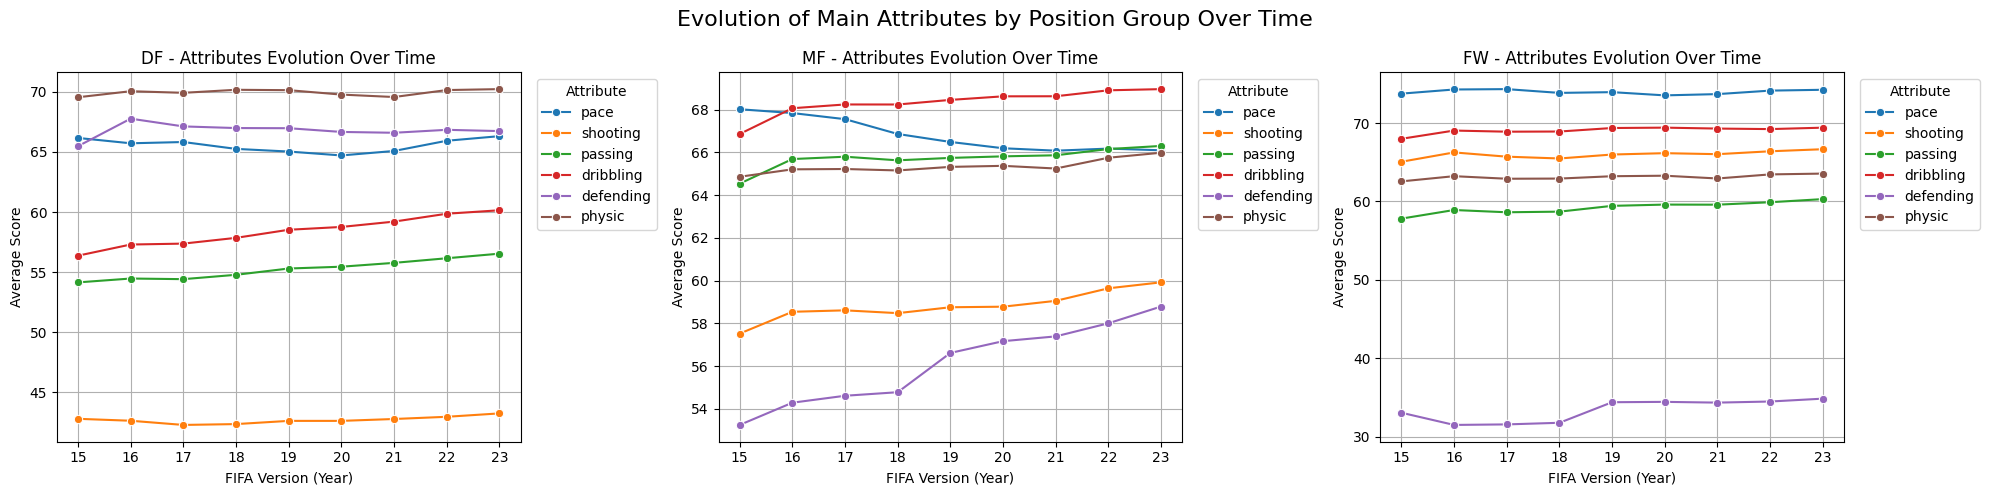

In [78]:
position_groups = ['DF', 'MF', 'FW']
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, pos in enumerate(position_groups):
    ax = axes[idx]
    pos_df = melted_df[(melted_df['position_group'] == pos) & (melted_df['attribute'].isin(main_attributes))]
    sns.lineplot(data=pos_df, x='fifa_version', y='avg_score', hue='attribute', marker='o', ax=ax)
    ax.set_title(f'{pos} - Attributes Evolution Over Time')
    ax.set_xlabel('FIFA Version (Year)')
    ax.set_ylabel('Average Score')
    ax.tick_params(axis='x', rotation=0)
    ax.legend(title='Attribute', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(True)

fig.suptitle('Evolution of Main Attributes by Position Group Over Time', fontsize=16)
plt.tight_layout()
plt.show()

Analyzing the evolution of average player attributes by position across FIFA editions provides an interesting lens for observing how tactical trends in contemporary football can be modeled and emphasized in-game. The charts show:
- **Core roles remain but with adjustments:** While the core positions remain specialised (Defensive/Physical Defenders, Passing/Dribbling Midfielders, Speed/Shooting Forwards), the change in average attributes shows an adaptation to modern tactics.
- **Increased Defensive Ability of Midfielders:** The most notable is the significant increase in the average Defensive attribute of the Midfielder (MF) group across editions. This clearly reflects the tactical trends in contemporary football, where midfielders are increasingly asked to participate in defensive work, from pressing high, covering the defence to recovering the ball in the midfield. Tactical systems such as Gegenpressing or formations with a mobile, versatile central midfielder are becoming increasingly popular.
- **The enduring importance of pace:** The pace attribute is quite stable in defenders and forwards. This emphasizes that, despite the increasing complexity of tactics, pace remains an extremely important factor in modern football, necessary for quick transitions, individual breakthroughs, or pressing and covering. However, in midfielders, there is a slight decrease, indicating the role of keeping the rhythm, controlling or regulating the tempo of the match.
- **A slight trend towards more well-rounded players:** The slight increase in some non-positional attributes (e.g. Passing/Dribbling in DF, Shooting/Physic in MF) may imply that modern football requires players in all positions to have a more diverse skill base to contribute to multiple aspects of the game, in line with tactics that emphasize versatility and positional interchangeability.
- **Traditional Strengths Remain Priorities:** Despite a slight ‘versatility’, the core attributes that characterize each position remain the ones with the highest and most consistent average scores. This suggests that regardless of tactical changes, having players who excel in the core skills appropriate to their position of expertise remains the key to success.

> **In summary, data from FIFA suggests that the most notable tactical change reflected is the increased role and defensive demands on midfielders, alongside the continued importance of pace and the (slight) demand for greater versatility from players in all positions.**

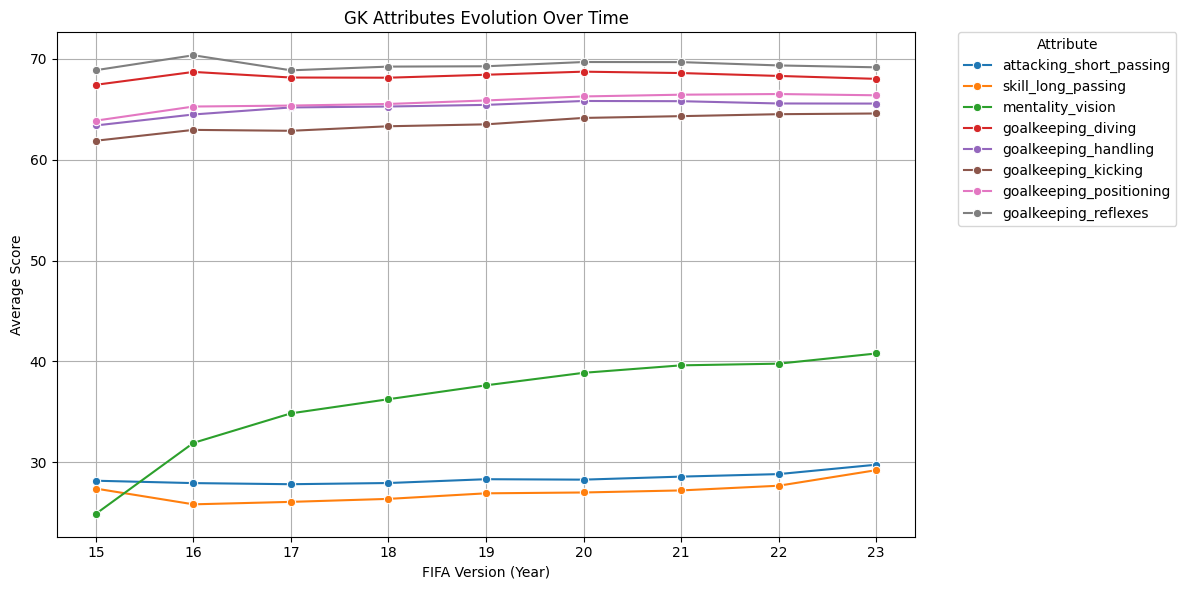

In [79]:
gk_attrs = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'attacking_short_passing', 'mentality_vision', 'skill_long_passing']
gk_df = melted_df[(melted_df['position_group'] == 'GK') & (melted_df['attribute'].isin(gk_attrs))]

plt.figure(figsize=(12, 6))
sns.lineplot(data=gk_df, x='fifa_version', y='avg_score', hue='attribute', marker='o')
plt.title('GK Attributes Evolution Over Time')
plt.xlabel('FIFA Version (Year)')
plt.ylabel('Average Score')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Attribute')

plt.tight_layout()
plt.grid(True)
plt.show()

- Footwork stats such as short passing, long passing have increased slightly over the years, especially vision has increased significantly, reflecting the need for goalkeepers to participate more in situations of developing the ball from the back line, and can play the role of a sweeper goalkeeper.
- Traditional stats such as diving, reflexes, positioning... remain stable over the years.
> **Modern goalkeepers must be good at both technical skills and coordination, becoming the "first initiator of attack".**

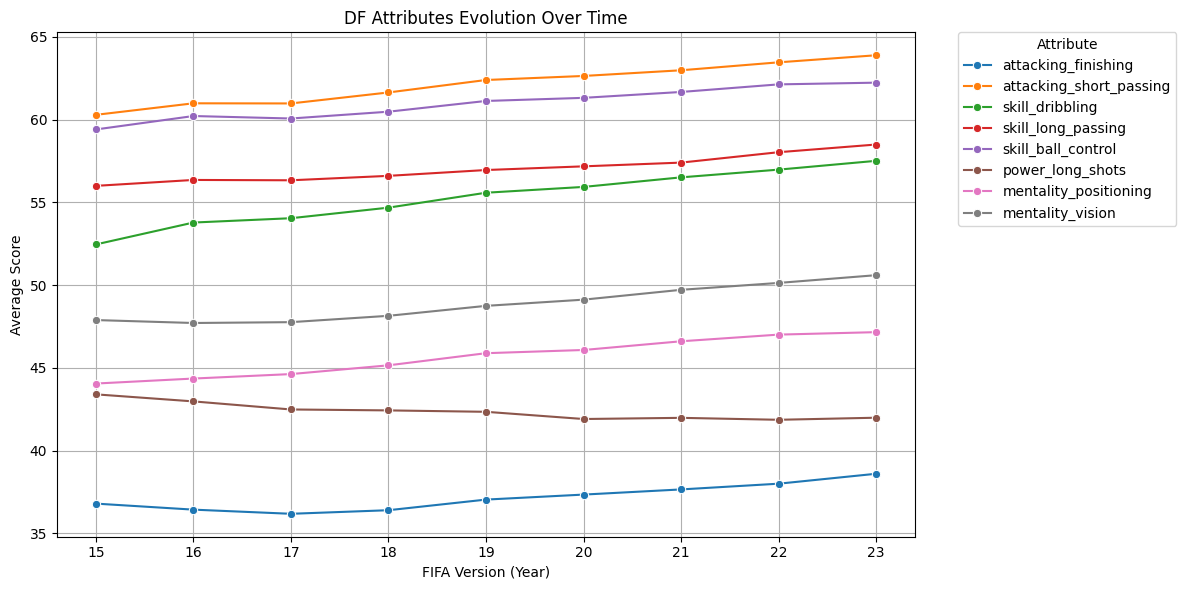

In [80]:
df_attrs = ['attacking_finishing', 'power_long_shots', 'attacking_short_passing', 'skill_long_passing', 'mentality_vision', 'skill_dribbling', 'ball_control', 'mentality_positioning', 'skill_ball_control', 'skill_long_passing']
df_df = melted_df[(melted_df['position_group'] == 'DF') & (melted_df['attribute'].isin(df_attrs))]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_df, x='fifa_version', y='avg_score', hue='attribute', marker='o')

plt.title('DF Attributes Evolution Over Time')
plt.xlabel('FIFA Version (Year)')
plt.ylabel('Average Score')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Attribute')

plt.tight_layout()
plt.grid(True)
plt.show()

**Modern defenders are significantly improving their ability to play with their feet:**
- Stats such as short passing, ball control, dribbling, long passing, vision have all increased steadily over the years.
- On the contrary, skills such as long shots and finishing have increased slowly, remained the same or decreased slightly, showing that the goal-scoring role of defenders has not changed much.
> **The trend of ball-playing defenders is becoming more and more obvious, they not only defend but also participate in build-up play, distributing the ball from the back line.**

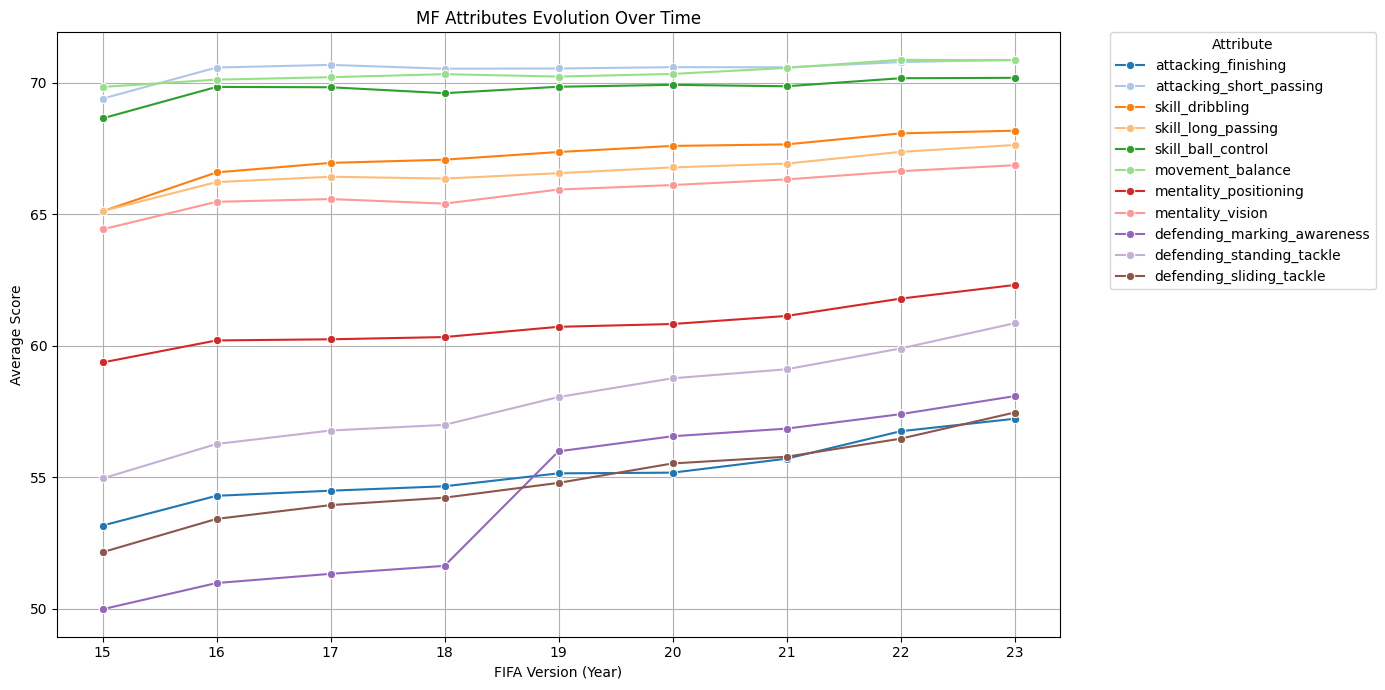

In [81]:
mf_attrs = ['attacking_finishing', 'mentality_positioning', 'skill_dribbling', 'skill_ball_control', 'attacking_short_passing', 'skill_long_passing', 'mentality_vision', 'defending_sliding_tackle', 'agility', 'movement_balance', 'defending_standing_tackle', 'defending_marking_awareness']
mf_df = melted_df[(melted_df['position_group'] == 'MF') & (melted_df['attribute'].isin(mf_attrs))]

plt.figure(figsize=(14, 7))
sns.lineplot(data=mf_df, x='fifa_version', y='avg_score', hue='attribute', marker='o', palette='tab20')

plt.title('MF Attributes Evolution Over Time')
plt.xlabel('FIFA Version (Year)')
plt.ylabel('Average Score')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Attribute')

plt.tight_layout()
plt.grid(True)
plt.show()

**Midfielders continue to be at the heart of tactics with consistent and consistent improvements in both:**
- Tactical thinking: positioning, vision
- Ball control & passing skills: short passing, long passing, dribbling, ball control
- Defensive ability: standing tackle, sliding tackle, marking awareness – increased sharply, especially in the period 2019–2023.
> **Shows the emergence of complete midfielders – both offensive and defensive, and controlling the tempo of the match.**

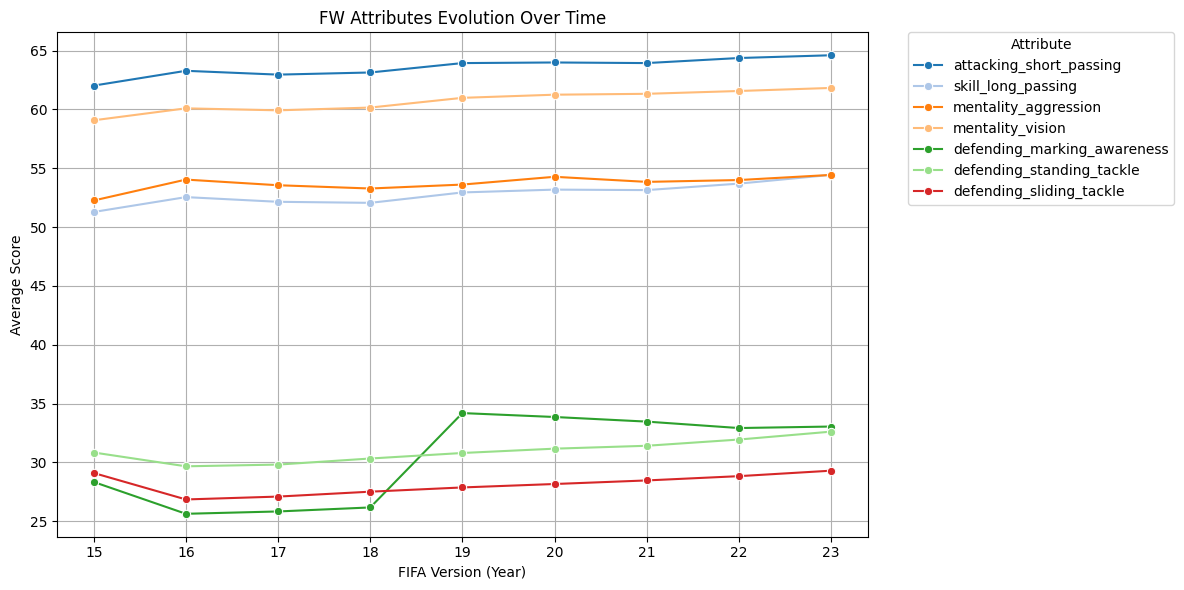

In [82]:
fw_attrs = ['attacking_short_passing', 'skill_long_passing', 'mentality_vision', 'mentality_aggression', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle']
fw_df = melted_df[(melted_df['position_group'] == 'FW') & (melted_df['attribute'].isin(fw_attrs))]

plt.figure(figsize=(12, 6))
sns.lineplot(data=fw_df, x='fifa_version', y='avg_score', hue='attribute', marker='o', palette='tab20')
plt.title('FW Attributes Evolution Over Time')
plt.xlabel('FIFA Version (Year)')
plt.ylabel('Average Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Attribute')
plt.tight_layout()
plt.grid(True)
plt.show()

**Forwards in this period also had changes in their playing style:**
- Slight increase in short passing and vision skills, showing the role of supporting attack coordination and connecting with the lines is increasingly clear.
- Defensive indicators increased steadily and continuously from 2016 - 2023 (standing tackle, sliding tackle), especially marking awareness increased sharply from 2018 - 2019, reflecting the trend of strikers having to actively participate in high pressing/defending from a distance.
> **Forwards in modern football are no longer "poachers" who just wait for the ball but are also the first link in the defensive system.**

**Conclusion**
> **In modern football, all positions have undergone significant evolution to adapt to increasingly complex tactical requirements and a higher pace of play. However, in terms of the ability to change and expand roles beyond traditional definitions, it can be said that the Goalkeeper (GK) and Defender (especially the full-back) are the two positions with the most obvious and revolutionary "evolution".**

### **What attributes of positions have changed significantly over the years?**


In [83]:
all_attributes = [
       'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

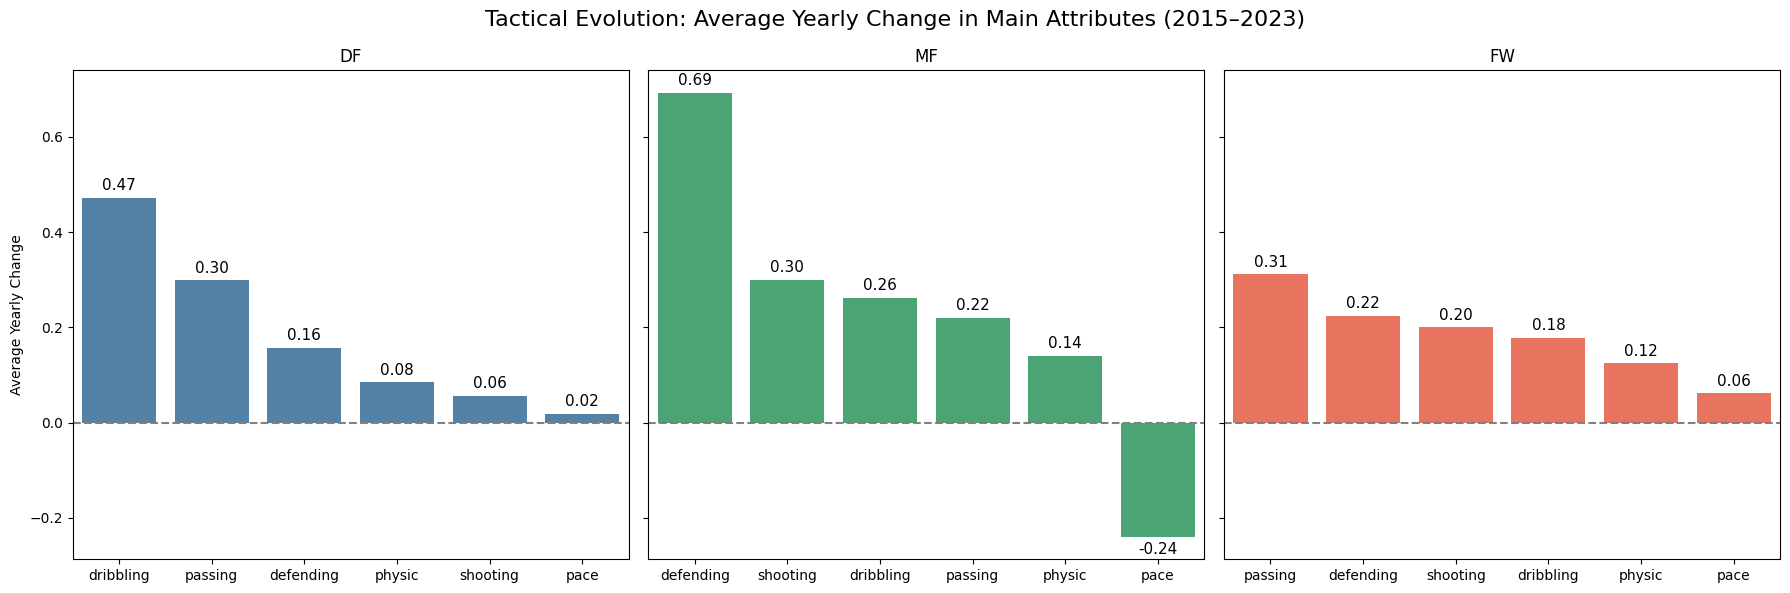

In [84]:
# Calculate the annual change
melted_main = melted_df[melted_df['attribute'].isin(main_attributes)].copy()
melted_main = melted_main.sort_values(['position_group', 'attribute', 'fifa_version'])
melted_main['delta'] = melted_main.groupby(['position_group', 'attribute'])['avg_score'].diff()

# Average annual change
avg_change = melted_main.groupby(['position_group', 'attribute'])['delta'].mean().reset_index()

# Draw chart with data labels
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
positions = ['DF', 'MF', 'FW']
colors = ['steelblue', 'mediumseagreen', 'tomato']

for i, pos in enumerate(positions):
    data = avg_change[avg_change['position_group'] == pos].sort_values('delta', ascending=False)
    ax = axes[i]
    barplot = sns.barplot(data=data, x='attribute', y='delta', color=colors[i], ax=ax)

    # Add data labels
    for p in barplot.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + 0.01 if height >= 0 else height - 0.01,
            f'{height:.2f}',
            ha='center',
            va='bottom' if height >= 0 else 'top',
            fontsize=11
        )

    ax.axhline(0, color='gray', linestyle='--')
    ax.set_title(f'{pos}')
    ax.set_xlabel('')
    ax.set_ylabel('Average Yearly Change')
    ax.tick_params(axis='x', rotation=0)

plt.suptitle('Tactical Evolution: Average Yearly Change in Main Attributes (2015–2023)', fontsize=16)
plt.tight_layout()
plt.show()

- Dribbling and Defending are the two most changed attributes
 - Defender (DF): Dribbling has increased the most, followed by Passing
➤ Defenders today need individual technique and the ability to deploy the ball from the back, not just pure defense.
 - Midfielder (MF): Defending has increased very strongly, surpassing Shooting and Dribbling
➤ Reflecting the trend of comprehensive midfielders: both organizing the play and participating in pressing, intercepting, and supporting defenders.
 - Forward (FW): Increasing steadily in many attributes, but Passing and Defending are notable
➤ Modern strikers not only know how to score goals but also participate in supporting pressing, building play, they are the first line of defense when the home team does not have the ball.

- Pace (speed) decreased significantly in midfielders, increased at least in the other 2 groups
➤ Shows that speed is no longer the decisive factor — instead, tactical thinking, coordination and movement without the ball are.

**📌 Conclusion**
- The most significant changes over the years are Dribbling (especially in defenders), Defending (clearly in midfielders), and Passing (in defenders and forwards).
- The general trend is that modern players need to be more versatile, supporting the overall play instead of just doing well in individual roles.
- Speed ​​(Pace) is no longer a priority as before.

### **Is there a shift in the tactics and playing style of football teams over time?**

> ***Here we do not analyze the tactics of a specific team because the tactics of each team or a specific group of teams are different and there are many teams, we only rely on the changes in the core attributes of the players to see the overall picture of the typical playing styles of the teams.***

<ipython-input-85-e69b735045f7>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_year = filtered_df.groupby(['fifa_version', 'attribute'])['avg_score'].mean().reset_index()


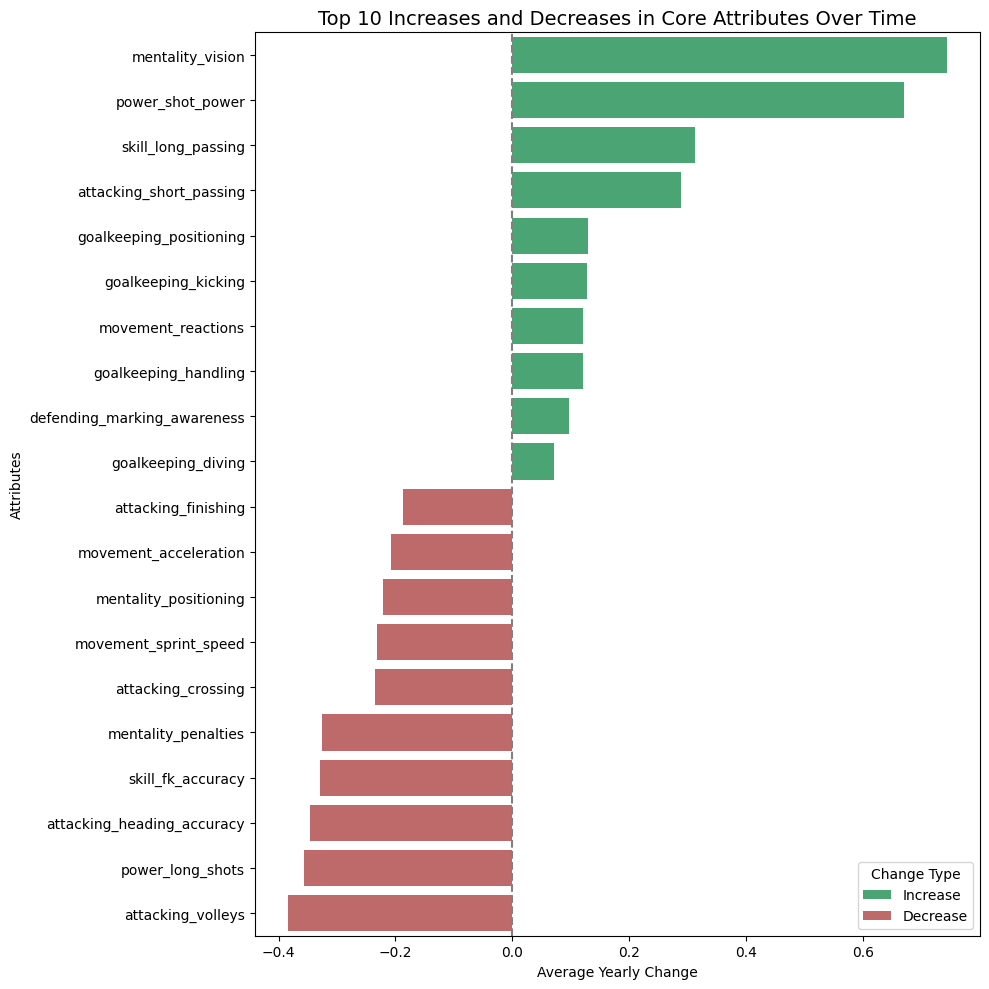

In [85]:
# Remove main attributes from all attributes
excluded_attrs = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
filtered_attributes = [attr for attr in all_attributes if attr not in excluded_attrs]

# Filter unpivoted data
filtered_df = melted_df[melted_df['attribute'].isin(filtered_attributes)]

# Average by year
avg_by_year = filtered_df.groupby(['fifa_version', 'attribute'])['avg_score'].mean().reset_index()

# Calculate delta
pivot_df = avg_by_year.pivot(index='fifa_version', columns='attribute', values='avg_score')
delta_per_year = pivot_df.diff().iloc[1:]

# Yearly average change
mean_delta = delta_per_year.mean().reset_index()
mean_delta.columns = ['attribute', 'avg_yearly_change']

# Get top 10 increases and decreases
top_increase = mean_delta.sort_values(by='avg_yearly_change', ascending=False).head(15)
top_decrease = mean_delta[~mean_delta['attribute'].isin(top_increase['attribute'])] \
                            .sort_values(by='avg_yearly_change').head(10)
top_increase = top_increase.head(10)

# Merge and assign label
top_changes = pd.concat([top_increase, top_decrease])
top_changes['change_type'] = top_changes['avg_yearly_change'].apply(lambda x: 'Increase' if x > 0 else 'Decrease')
top_changes_sorted = top_changes.sort_values(by='avg_yearly_change', ascending=False)

# Draw chart
plt.figure(figsize=(10, 10))
sns.barplot(
    data=top_changes_sorted,
    y='attribute', x='avg_yearly_change',
    hue='change_type',
    dodge=False,
    palette={'Increase': 'mediumseagreen', 'Decrease': 'indianred'}
)

plt.axvline(0, color='gray', linestyle='--')
plt.title('Top 10 Increases and Decreases in Core Attributes Over Time', fontsize=14)
plt.xlabel('Average Yearly Change')
plt.ylabel('Attributes')
plt.legend(title='Change Type', loc='lower right')
plt.tight_layout()
plt.show()

From this chart we can see that there has been a clear shift in the tactical meta of football during this period:
- **Volleys** have dropped the most, showing that **live shots that score goals are no longer popular** and that there are no players with good volleying ability during this period.
- **Long shots** have dropped the second most, showing that teams are **no longer relying on long-range shots** to score goals, but are shifting to **more methodical and calculated combinations.**
- **Crossing and heading accuracy are both in the top 10 of the biggest declines**, showing that teams are **no longer favoring the Anglo-Saxon style of overlapping, cross-heading or corner kicks** to score goals, which often relies heavily on **high-ball situations**.
- The indicators such as **vision, long passing, short passing, reactions and marking awareness** are all in the top 10 with the strongest increase, which reflects the **synchronous pressing and escaping pressing style from many lines that requires the ability to control, pass the ball, catch people and react quickly**, a hallmark of in modern football.
- The **goalkeeper's index** sets have also increased significantly over the years, showing that **goalkeepers must be more and more comprehensive and excellent** because in modern football, a save is no different from a goal, especially in big matches.

**Conclusion**
> **Football has always been in constant motion and change throughout its history, with increasingly high and complex tactical requirements, players also need to change to adapt, they are no longer constrained in traditional roles but are increasingly flexible and versatile.**

## **Part 2 – The Making of a Great Player**
> ***This study focuses on in-game attributes only, not real-life performance metrics.***

### **What main attributes make a great player?**

> ***Analysis is based on player attributes in EA FIFA game data, which reflect a gamified interpretation of real-life performance.***



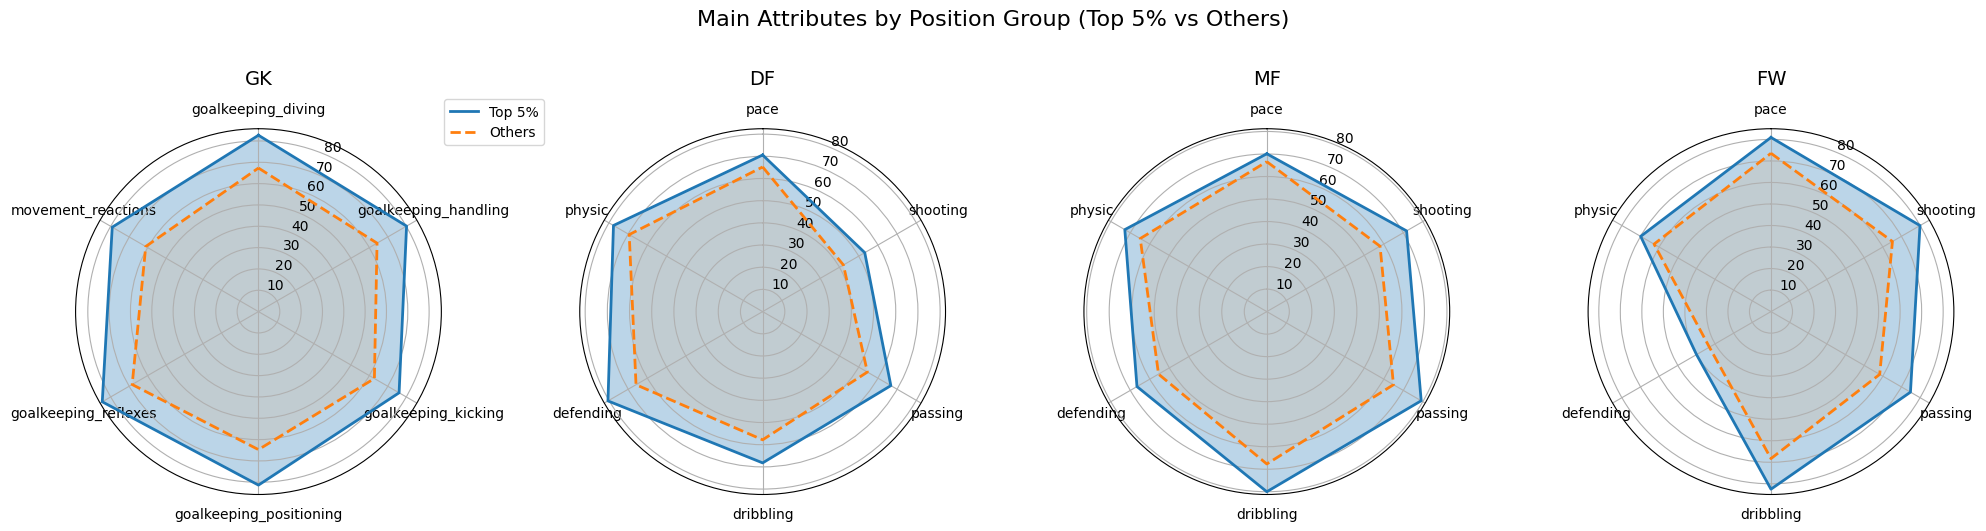

In [86]:
gk_attributes = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'movement_reactions']
position_groups_order = ['GK', 'DF', 'MF', 'FW']

# --- Create Figure and Subplots ---
fig, axs = plt.subplots(1, 4, figsize=(20, 6), subplot_kw=dict(polar=True))
fig.suptitle('Main Attributes by Position Group (Top 5% vs Others)', fontsize=16, y=0.95)

# --- Loop through Position Groups and Plot Radar Charts ---
for i, pos in enumerate(position_groups_order):
    if pos == 'GK':
        current_attributes = gk_attributes
    else:
        current_attributes = main_attributes

    # Filter players by position group
    pos_df = ff23_df[ff23_df['position_group'] == pos].copy()

    # Calculate Top 5% threshold based on 'overall' rating within the group
    threshold = pos_df['overall'].quantile(0.95)
    top5 = pos_df[pos_df['overall'] >= threshold]
    others = pos_df[pos_df['overall'] < threshold]

    # Calculate mean of the selected attributes for Top 5% and Others
    avg_top5 = top5[current_attributes].mean().values
    avg_others = others[current_attributes].mean().values

    # --- Radar chart setup ---
    labels = current_attributes
    num_vars = len(labels)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    top5_scores = list(avg_top5) + [avg_top5[0]]
    others_scores = list(avg_others) + [avg_others[0]]

    # --- Plot data ---
    ax = axs[i]
    ax.plot(angles, top5_scores, linewidth=2, linestyle='solid', label='Top 5%')
    ax.fill(angles, top5_scores, alpha=0.3)
    ax.plot(angles, others_scores, linewidth=2, linestyle='dashed', label='Others')
    ax.fill(angles, others_scores, alpha=0.1)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids([a * 180/pi for a in angles[:-1]], labels)
    ax.set_title(f'{pos}', y=1.1, fontsize=14)

    # Add legend only to the first plot for clarity
    if i == 0:
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

- **Goalkeepers (GK):** Top 5% excel in **Diving, Handling, Positioning, Reflexes, Reactions.**
> A top goalkeeper cannot lack any GK skills – from reflexes, positioning to ball handling. **Reactions** play a key role in dealing with dangerous situations.
- **Defenders (DF):** Top 5% have superior **Defending**, along with significantly higher **Passing, Dribbling, Shooting.**
> Modern defenders must not only defend well but also **handle the ball, pass the ball and support the attack.** Pace does not need to be too high if they can read the situation well.
- **Midfielders (MF):** The biggest difference lies in **Passing, Dribbling**, followed by Shooting.
> A great midfielder is someone who **holds the ball well, passes creatively and has the ability to finish the situation.** They dictate play and create chances for their teammates and themselves.
- **Forwards (FW):**
> Top 10% excel in **Shooting, Dribbling, Passing** – the ultimate attacking skill set.
> Legendary forwards are those who **can decide the game with their individual skill** and scoring ability.

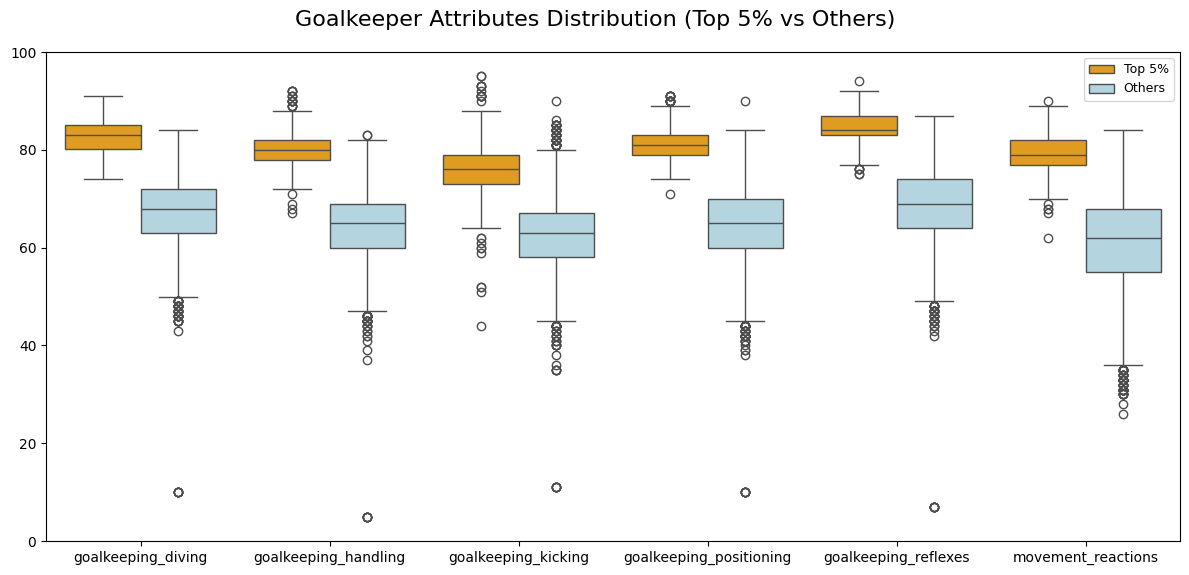

In [87]:
# Create Legend Group sorting column (Top 5% vs Others)
ff23_df['legend_group'] = ff23_df.groupby('position_group')['overall'] \
    .transform(lambda x: ['Top 5%' if val >= x.quantile(0.95) else 'Others' for val in x])

# Setup figure
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Goalkeeper Attributes Distribution (Top 5% vs Others)', fontsize=16, y=0.95)

# Draw single boxplot chart for GK
sns.boxplot(
    data=ff23_df[ff23_df['position_group'] == 'GK'].melt(
        id_vars='legend_group',
        value_vars=gk_attributes,
        var_name='Attribute',
        value_name='Value'
    ),
    x='Attribute',
    y='Value',
    hue='legend_group',
    palette={'Top 5%': 'orange', 'Others': 'lightblue'},
    ax=ax
)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0, 100)
ax.legend(loc='upper right', fontsize=9).set_title('')

# Clean up layout
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

- In the **goalkeeper (GK)** group, the players in the **top 5%** have a **well-rounded and consistent skill set.** They are not just excellent in a few stats, but are **equally good in all the mandatory aspects** of the GK position – from **reflexes, positioning, kicking** to **reactions.**
- The Top 5% group has a shorter box, meaning low variability and few outliers, for example goalkeeping_reflexes and movement_reactions of the Top 5% group are both concentrated around 80–88. This implies that **Legend GKs are consistent**, maintaining a **high level of performance regardless of temporary fluctuations** in form.
- Notably, **reactions** and **reflexes** are the attributes that show the biggest gap between the Legend group and the rest – this is related to the ability to **make spectacular saves**, which is **what makes a great goalkeeper.**

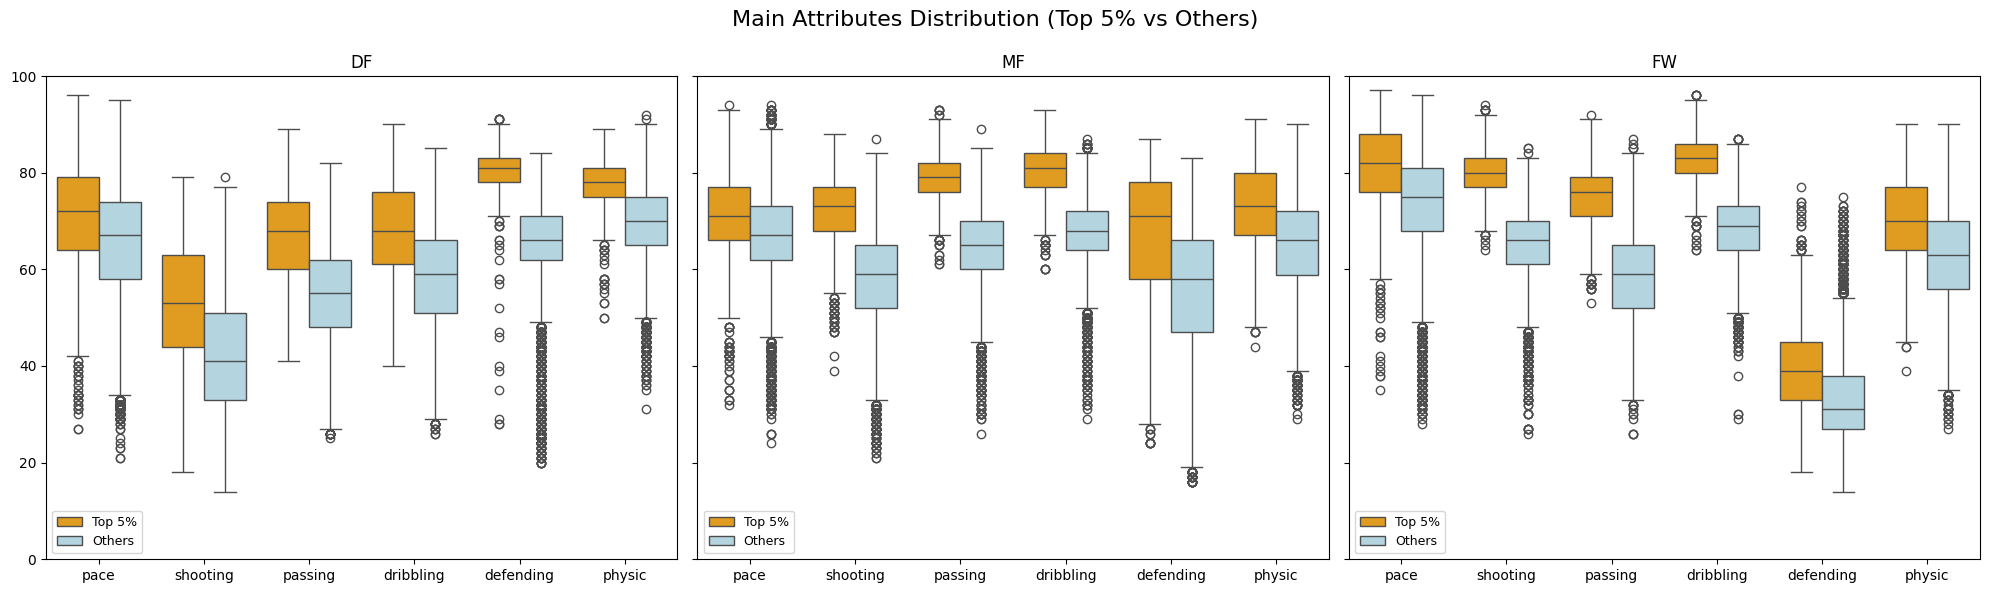

In [88]:
# Create sorting columns for DF/MF/FW to force display order
ff23_df['position_group_ordered'] = ff23_df['position_group'].copy()
ff23_df.loc[~ff23_df['position_group_ordered'].isin(['DF', 'MF', 'FW']), 'position_group_ordered'] = pd.NA
ff23_df['position_group_ordered'] = pd.Categorical(
    ff23_df['position_group_ordered'],
    categories=['DF', 'MF', 'FW'],
    ordered=True
)

# Setup figure
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle('Main Attributes Distribution (Top 5% vs Others)', fontsize=16, y=0.98)

# Draw boxplot
for i, pos in enumerate(['DF', 'MF', 'FW']):
    sns.boxplot(
        data=ff23_df[ff23_df['position_group_ordered'] == pos].melt(
            id_vars=['legend_group'],
            value_vars=main_attributes,
            var_name='Attribute',
            value_name='Value'
        ),
        x='Attribute',
        y='Value',
        hue='legend_group',
        palette={'Top 5%': 'orange', 'Others': 'lightblue'},
        ax=axs[i]
    )
    axs[i].set_title(pos)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0, 100)
    axs[i].legend(loc='best', fontsize=9).set_title('')

# Clean up layout
plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.show()

- **Overall:**
 - Across all metrics and roles, the **Top 5% are clearly superior** to the rest.
 - Not only do they have higher median values, but the **Top 5% are also more consistent** (shorter boxes, fewer outliers), showing that they are well-rounded and consistent players.
- **Defenders (DF):**
 - **Defending** is the most prominent strength, with the Top 5% having a median >80 compared to the rest of the group around ~65.
 - **Dribbling, Passing and Physic** also stand out, showing that today's top defenders are not only defensive but also participate in building play and competing strongly.
 - There is also a difference in **Pace** - speed is the factor that distinguishes normal defenders from top defenders.
>✅ *A Great Defender is not only good at defending but also has good speed, stamina and ball handling technique.*
- **Midfielders (MF):**
 - **Passing and Dribbling** are the two most distinguishing factors – Top 5% have excellent passing and dribbling abilities (~80 and above).
 - **Shooting, Defending and Physic** are also slightly better, showing that they are not only playmakers but can also defend or score directly when needed.
 - The difference in **pace** is less, a good midfielder does not need to be too fast.
> ✅ *A Great Midfielder is a versatile player, capable of controlling the game with technique and physicality, while contributing to both attack and defense.*

- **Forwards (FW):**
 - **Shooting** is the most distinguishing factor – Top 5% have median >80, while the other group ~65.
 - **Dribbling and Passing** are also clearly superior, showing that ball handling and passing skills are core factors.
 - **Pace and Physic** are also better – a great forward is not only a goal scorer but also has good physicality and speed.
> ✅ *A Great Forward is a player with excellent scoring ability, good dribbling and coordination, and has the speed to break through to create breakthroughs.*

**Conclusion**
> *In every position, the Top 5% players not only excel in a specific stat, but also have a **comprehensive and consistent performance**. The biggest difference between them and the rest lies in the core skills of each position – for example: Reflexes & Reactions for Goalkeepers, Passing & Dribbling for Midfielders or Shooting & Dribbing for Forwards. It is this **consistent excellence** that is the foundation for creating a great player in football.*

### **What core attributes make a great player?**
> ***Based on EA FIFA player attributes, what are the core features that distinguish top 5% players from the rest?***


In [89]:
# Remove main attributes
detail_attributes = [attr for attr in all_attributes if attr not in main_attributes]

# Create a Top 5% classification label column (great_target)
ff23_df['great_target'] = ff23_df.groupby('position_group')['overall'] \
    .transform(lambda x: (x >= x.quantile(0.95)).astype(int))

# Prepare data for training
X = ff23_df[detail_attributes]
y = ff23_df['great_target']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Logistic Regression
lg_model = LogisticRegression(max_iter=1000)
lg_model.fit(X_scaled, y)

LogisticRegression(max_iter=1000)

In [90]:
# Predict on the same data
y_pred = lg_model.predict(X_scaled)
y_proba = lg_model.predict_proba(X_scaled)[:, 1] # Get class 1 probability

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y, y_pred))

Confusion Matrix:
[[64206   611]
 [ 1177  2836]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     64817
           1       0.82      0.71      0.76      4013

    accuracy                           0.97     68830
   macro avg       0.90      0.85      0.87     68830
weighted avg       0.97      0.97      0.97     68830



In [91]:
# Classification report table
report_dict = classification_report(y, y_pred, output_dict=True)
class_rp = pd.DataFrame(report_dict).transpose()
columns_to_keep = ['precision', 'recall', 'f1-score', 'support']
class_rp = class_rp[columns_to_keep].round(2)
accuracy_value = class_rp.loc['accuracy', 'precision']
class_rp.loc['accuracy'] = [accuracy_value, np.nan, np.nan, np.nan]
class_rp

,precision,recall,f1-score,support
0,0.98,0.99,0.99,64817.0
1,0.82,0.71,0.76,4013.0
accuracy,0.97,NaN,NaN,NaN
macro avg,0.90,0.85,0.87,68830.0
weighted avg,0.97,0.97,0.97,68830.0


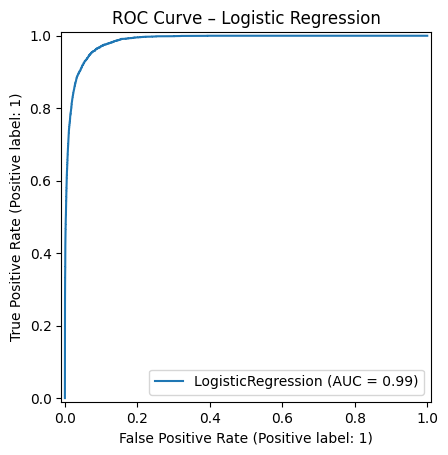

In [92]:
# ROC Curve
RocCurveDisplay.from_estimator(lg_model, X_scaled, y)
plt.title("ROC Curve – Logistic Regression")
plt.show()

Based on classification report and ROC Curve:
- Overall performance is very good: **Accuracy 97%**, **ROC AUC 0.99** → the model distinguishes very well between top 5% players and the rest.
- The model achieves: **Precision = 0.82** and **Recall = 0.71** for class 1 (top 5% excellent players), meaning the model correctly detects many "great" players, **limiting false positives relatively well.**
- Note the imbalance of the data set: Class 1 only accounts for **about 6%** of the data set, this explains why Recall class 1 = 0.71, lower than class 0. However, **high precision** for class 1 is a positive point.

> ✅ Logistic Regression Model Easy to understand, simple, shows very good efficiency in classifying "great players". Used to **determine the core attributes that make a great player** (via coefficients).

In [93]:
# Analyze feature importance
importance_df = pd.DataFrame({'attribute': detail_attributes, 'coefficient': lg_model.coef_[0]})
importance_df['abs_coef'] = importance_df['coefficient'].abs()
importance_df = importance_df.sort_values(by='abs_coef', ascending=False)

# Display Top 15 most important features
top_features = importance_df.head(15)
top_features

,attribute,coefficient,abs_coef
13,movement_reactions,4.198884,4.198884
22,mentality_positioning,-1.719533,1.719533
9,skill_ball_control,1.401171,1.401171
33,goalkeeping_reflexes,1.253902,1.253902
3,attacking_short_passing,1.024084,1.024084
11,movement_sprint_speed,0.907733,0.907733
2,attacking_heading_accuracy,0.835134,0.835134
29,goalkeeping_diving,0.823387,0.823387
30,goalkeeping_handling,0.779898,0.779898
25,mentality_composure,0.750322,0.750322


<ipython-input-94-5dd2a44c165b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


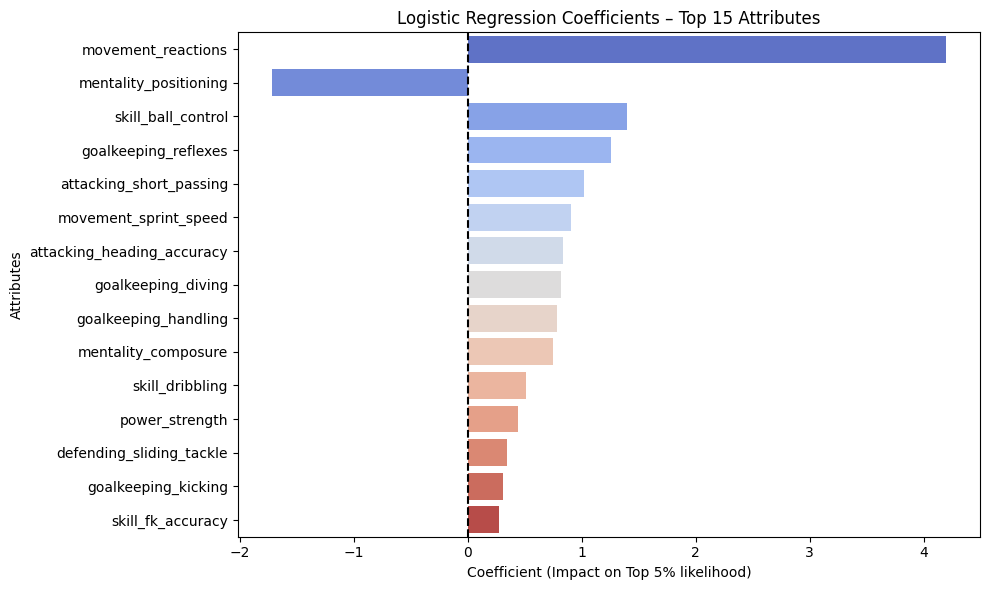

In [94]:
# Draw Top 15 most important features
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features,
    y='attribute',
    x='coefficient',
    palette='coolwarm'
)
plt.axvline(0, color='black', linestyle='--')
plt.title('Logistic Regression Coefficients – Top 15 Attributes')
plt.xlabel('Coefficient (Impact on Top 5% likelihood)')
plt.ylabel('Attributes')
plt.tight_layout()
plt.show()

"What core attributes make a great player?"
The most important attributes (by coefficient):
- **Reactions (↑)** - Highest coefficient:
 - **The ability to react to second-ball situations in the match** is the most important factor that helps distinguish the top 5% players.
 - "Great" players often react quickly to situations, making the difference in important moments.
- **Positioning (↓)** - Highest negative coefficient. Although it seems paradoxical, the negative coefficient here **does not mean that this index is bad**, but it can be due to:
 - This index is often high in forwards, not common in midfielders or defenders
 - Or because this variable is negatively correlated with being in the top 5% because the model differentiates by position.
- **Ball control (↑)** and **short passing (↑)**
→ Technical ball handling, control and short passing skills are important for top players.
- **Reflexes (↑)** and other GK stats → Suggests that the top 5% also **include excellent goalkeepers**, who are considered half of the team.
- **Sprint speed (↑)** and **heading accuracy (↑)** → Sprint speed and heading ability – typical skills of high-class forwards.

> 📌 The best players usually possess:
- **Quick reactions**
- **Good ball control and short passing**
- **High speed**
- **Role-specific skills – such as reflexes (GK), short passing (MF) or heading accuracy (FW)**

**Conclusion**
> ***Apart from the goalkeeper position, which is a very special position in football, we can see that the most core attributes of a great player are all in the stats that serve the ability to attack and find goals. This means that a midfielder or forward who plays well will always have an advantage over a defender in the race for individual titles, which is absolutely true in modern football.***

## **Part 3 - Market Pulse: Underrated vs Overrated**

### **What factors greatly affect a player's value?**

In [95]:
country_continent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Continent  196 non-null    object
 1   Country    196 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [96]:
country_continent_df.rename(columns={'Continent': 'continent', 'Country': 'country'}, inplace=True)

In [97]:
country_continent_df = country_continent_df.drop_duplicates(keep='first', ignore_index=True)

In [98]:
country_continent_df['continent'].unique()

array(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America'], dtype=object)

In [99]:
country_continent_df['country'].unique()

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina', 'Burundi',
       'Cameroon', 'Cape Verde', 'Central African Republic', 'Chad',
       'Comoros', 'Congo', 'Democratic Republic of Congo', 'Djibouti',
       'Egypt', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon',
       'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Ivory Coast',
       'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi',
       'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique',
       'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe',
       'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa',
       'South Sudan', 'Sudan', 'Swaziland', 'Tanzania', 'Togo', 'Tunisia',
       'Uganda', 'Zambia', 'Zimbabwe', 'Afghanistan', 'Bahrain',
       'Bangladesh', 'Bhutan', 'Brunei', 'Burma (Myanmar)', 'Cambodia',
       'China', 'East Timor', 'Hong Kong', 'India', 'Indonesia', 'Iran',
       'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'North Korea',
       '

In [100]:
ff23_df['nationality_name'].unique()

array(['Argentina', 'Portugal', 'Netherlands', 'Sweden', 'Germany',
       'Uruguay', 'France', 'Belgium', 'Spain', 'Brazil', 'Wales',
       'Croatia', 'Poland', 'England', 'Czech Republic', 'Chile', 'Italy',
       'Turkey', 'Morocco', 'Serbia', 'Russia', 'Peru', 'Japan',
       'Colombia', 'United States', 'Mexico', 'Slovakia', 'Denmark',
       'Austria', 'Cameroon', 'Bulgaria', 'Montenegro', 'Algeria',
       'Armenia', 'Togo', 'Switzerland', 'Nigeria', 'Ecuador', 'Ghana',
       'Senegal', 'Venezuela', 'South Africa', 'Finland', 'Paraguay',
       'Hungary', 'Gabon', 'Costa Rica', 'Tunisia', 'North Macedonia',
       'Greece', 'Ukraine', 'Mali', 'Congo', 'Albania', 'Benin',
       'Romania', 'Slovenia', 'Guinea', 'Australia', 'Northern Ireland',
       'Scotland', 'Norway', 'Egypt', 'Lithuania', 'New Zealand',
       'Burkina Faso', 'Kenya', 'Georgia', 'Iceland', 'Mozambique',
       'Estonia', 'Oman', 'Uzbekistan', 'Angola', 'Latvia', 'Belarus',
       'Trinidad and Tobago', 'Ho

In [101]:
manual_country_map = {
    "aruba": "netherlands", "bermuda": "united kingdom", "brunei darussalam": "brunei", "burkina faso": "burkina", "cape verde islands": "cape verde",
    "china pr": "china", "chinese taipei": "taiwan", "congo dr": "democratic republic of congo", "curacao": "netherlands",
    "czech republic": "czechia", "côte d'ivoire": "ivory coast", "england": "united kingdom", "faroe islands": "denmark",
    "gibraltar": "united kingdom", "guam": "united states", "guinea bissau": "guinea-bissau", "korea dpr": "north korea", "korea republic": "south korea",
    "kosovo": "serbia", "macau": "china", "montserrat": "united kingdom", "new caledonia": "france", "north macedonia": "macedonia",
    "northern ireland": "united kingdom", "palestine": "palestine", "puerto rico": "united states", "republic of ireland": "ireland",
    "scotland": "united kingdom", "são tomé e príncipe": "sao tome and principe", "timor-leste": "east timor", "wales": "united kingdom"
}

# Normalize country name
ff23_df['nationality_clean'] = ff23_df['nationality_name'].str.strip().str.lower()
country_continent_df['country_clean'] = country_continent_df['country'].str.strip().str.lower()

# Apply manual mapping
ff23_df['nationality_clean'] = ff23_df['nationality_clean'].replace(manual_country_map)

# Merge continent data into ff23_df
ff23_df = ff23_df.merge(country_continent_df[['country_clean', 'continent']], left_on='nationality_clean', right_on='country_clean', how='left')

# Delete unnecessary columns
ff23_df.drop(columns=['country_clean', 'nationality_clean'], inplace=True)

In [102]:
# Check missing values
missing = ff23_df[ff23_df['continent'].isna()]['nationality_name'].unique()
print("Countries unmatched:", missing)

Countries unmatched: ['Palestine']


In [103]:
ff23_df.loc[ff23_df['nationality_name'] == 'Palestine', 'continent'] = 'Asia'

In [104]:
# One-hot encode continent column
continent_dummies = pd.get_dummies(ff23_df['continent'], prefix='continent')

# Rename columns to lowercase and remove prefix
continent_dummies.rename(columns={
    'continent_Africa': 'africa',
    'continent_Asia': 'asia',
    'continent_Europe': 'europe',
    'continent_North America': 'north_america',
    'continent_Oceania': 'oceania',
    'continent_South America': 'south_america'
}, inplace=True)

# Merge into original DataFrame
ff23_df = pd.concat([ff23_df, continent_dummies], axis=1)

In [105]:
ff23_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68830 entries, 0 to 68829
Data columns (total 79 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   player_id                    68830 non-null  int64         
 1   fifa_version                 68830 non-null  category      
 2   short_name                   68830 non-null  object        
 3   long_name                    68830 non-null  object        
 4   player_positions             68830 non-null  object        
 5   overall                      68830 non-null  int64         
 6   potential                    68830 non-null  int64         
 7   value_eur                    68830 non-null  float64       
 8   wage_eur                     68830 non-null  float64       
 9   age                          68830 non-null  int64         
 10  date_of_birth                68830 non-null  datetime64[ns]
 11  height_cm                    68830 non-nu

In [106]:
ff23_df['work_rate'].unique()

['Medium/Low', 'High/Low', 'Medium/Medium', 'High/Medium', 'High/High', 'Medium/High', 'Low/Medium', 'Low/High', 'Low/Low']
Categories (9, object): ['High/High', 'High/Low', 'High/Medium', 'Low/High', ..., 'Low/Medium',
                         'Medium/High', 'Medium/Low', 'Medium/Medium']

In [107]:
# 1. Split work_rate into 2 columns
ff23_df[['attacking_work_rate', 'defending_work_rate']] = ff23_df['work_rate'].str.split('/', expand=True)

# 2. Assign values ​​in order
work_rate_map = {'Low': 0, 'Medium': 1, 'High': 2}

ff23_df['attacking_work_rate'] = ff23_df['attacking_work_rate'].map(work_rate_map)
ff23_df['defending_work_rate'] = ff23_df['defending_work_rate'].map(work_rate_map)

In [108]:
ff23_df['player_tags'].unique()

array(['#Speedster, #Dribbler, #FK Specialist, #Acrobat, #Clinical Finisher, #Complete Forward',
       '#Speedster, #Dribbler, #Distance Shooter, #Acrobat, #Clinical Finisher, #Complete Forward',
       '#Speedster, #Dribbler, #Distance Shooter, #Acrobat',
       '#Poacher, #Aerial Threat, #Distance Shooter, #Acrobat, #Strength, #Clinical Finisher, #Complete Forward',
       nan, '#Acrobat, #Clinical Finisher',
       '#Distance Shooter, #Clinical Finisher',
       '#Playmaker, #Engine, #Tactician\xa0', '#Dribbler, #Acrobat',
       '#Speedster, #Dribbler, #Acrobat',
       '#Engine, #Tackling, #Tactician\xa0', '#Tackling, #Tactician\xa0',
       '#Dribbler, #Playmaker, #Acrobat', '#Speedster, #Distance Shooter',
       '#Clinical Finisher', '#Playmaker, #FK Specialist',
       '#Engine, #Distance Shooter, #Clinical Finisher',
       '#Tackling, #Tactician, #Strength, #Complete Defender',
       '#Dribbler, #Playmaker\xa0',
       '#Aerial Threat, #Tackling, #Tactician, #Strength, #Co

In [109]:
# Covert to string
ff23_df['player_tags'] = ff23_df['player_tags'].fillna('').astype(str)
ff23_df['tag_list'] = ff23_df['player_tags'].apply(parse_tag_list)

# One-hot encoding
mlb = MultiLabelBinarizer()
tag_dummies = pd.DataFrame(mlb.fit_transform(ff23_df['tag_list']),
                           columns=[tag.lower().replace(' ', '_') for tag in mlb.classes_],
                           index=ff23_df.index)

# Merge and remove temporary column
ff23_df = pd.concat([ff23_df.drop(columns=['tag_list']), tag_dummies], axis=1)

In [110]:
ff23_df['player_traits'].unique()

array(['Finesse Shot, Speed Dribbler (AI), One Club Player, Team Player',
       'Power Free-Kick, Flair, Long Shot Taker (AI), Speed Dribbler (AI)',
       'Diver, Injury Prone, Avoids Using Weaker Foot, Selfish, Long Shot Taker (AI), Speed Dribbler (AI), Chip Shot (AI)',
       ..., 'Playmaker (AI), Power Header',
       'Injury Prone, Dives Into Tackles (AI), Flair, Speed Dribbler (AI)',
       'Solid Player, Flair, Long Shot Taker (AI), Playmaker (AI)'],
      dtype=object)

In [111]:
# Covert to string
ff23_df['player_traits'] = ff23_df['player_traits'].fillna('').astype(str)

# Split into list of traits (remove extra whitespace)
ff23_df['trait_list'] = ff23_df['player_traits'].apply(lambda x: [trait.strip() for trait in x.split(',') if trait.strip()])

# One-hot encoding
mlb_traits = MultiLabelBinarizer()
trait_dummies = pd.DataFrame(mlb_traits.fit_transform(ff23_df['trait_list']),
                             columns=[trait.lower().replace(' ', '_').replace('(', '').replace(')', '') for trait in mlb_traits.classes_],
                             index=ff23_df.index)

# Merge and remove temporary column
ff23_df = pd.concat([ff23_df.drop(columns=['trait_list']), trait_dummies], axis=1)

In [112]:
# One-hot encode preferred_foot column
foot_dummies = pd.get_dummies(ff23_df['preferred_foot'], prefix='', prefix_sep='')

# Rename columns
foot_dummies.rename(columns={
    'Left': 'left_preferred_foot',
    'Right': 'right_preferred_foot'
}, inplace=True)

# Merge into original DataFrame
ff23_df = pd.concat([ff23_df, foot_dummies], axis=1)

In [113]:
# One-hot encode position_group column
pos_group_dummies = pd.get_dummies(ff23_df['position_group'], prefix='', prefix_sep='')

# Merge into original DataFrame
ff23_df = pd.concat([ff23_df, pos_group_dummies], axis=1)

In [114]:
ff23_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68830 entries, 0 to 68829
Data columns (total 126 columns):
 #    Column                       Dtype         
---   ------                       -----         
 0    player_id                    int64         
 1    fifa_version                 category      
 2    short_name                   object        
 3    long_name                    object        
 4    player_positions             object        
 5    overall                      int64         
 6    potential                    int64         
 7    value_eur                    float64       
 8    wage_eur                     float64       
 9    age                          int64         
 10   date_of_birth                datetime64[ns]
 11   height_cm                    int64         
 12   weight_kg                    int64         
 13   club_name                    object        
 14   nationality_name             object        
 15   preferred_foot               categ

In [115]:
# Target variable
y = ff23_df['value_eur']

# Factors
cols_to_exclude = [
    'player_id', 'fifa_version', 'short_name', 'long_name', 'player_positions', 'date_of_birth', 'club_name',
    'nationality_name', 'preferred_foot', 'work_rate', 'body_type', 'player_tags', 'player_traits', 'name',
    'join_key', 'position', 'position_group', 'value_eur', 'overall', 'pace', 'shooting', 'passing', 'dribbling',
    'defending', 'physic', 'legend_group', 'position_group_ordered', 'continent', 'great_target', 'market_year', 'market_value_in_eur'
]

X = ff23_df.drop(columns=cols_to_exclude)

In [116]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

In [117]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

In [118]:
# Print Comparison
print("=== Linear Regression ===")
print(f"MAE : {mae_lr:,.0f}")
print(f"RMSE: {rmse_lr:,.0f}")
print(f"R²  : {r2_lr:.4f}")

print("\n=== Random Forest ===")
print(f"MAE : {mae_rf:,.0f}")
print(f"RMSE: {rmse_rf:,.0f}")
print(f"R²  : {r2_rf:.4f}")

=== Linear Regression ===
MAE : 2,469,849
RMSE: 4,954,150
R²  : 0.6620

=== Random Forest ===
MAE : 811,567
RMSE: 2,351,944
R²  : 0.9238


In [119]:
LR_RF_Comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE': [2469849, 811567],
    'RMSE': [4954150, 2351944],
    'R²': [0.6620, 0.9238]
})
LR_RF_Comparison

,Model,MAE,RMSE,R²
0,Linear Regression,2469849,4954150,0.6620
1,Random Forest,811567,2351944,0.9238


The comparison between **Linear Regression** and **Random Forest** clearly demonstrates the superiority of Random Forest:
- The **MAE (Mean Absolute Error)** of Random Forest is only around **803k**, while Linear Regression is nearly **three times higher (~2.1 million)** → indicating that Random Forest predicts much closer to actual values.
- The **RMSE (Root Mean Squared Error)** of Random Forest is **also almost half** that of Linear Regression **(2.3 million vs 4.6 million)** → confirming its ability to reduce large errors.
- The **R² Score** of Random Forest reaches **0.9253**, showing that the model explains **92.53% of the variance** in the data, much higher than Linear Regression (**70.9%**).

👉 **Conclusion:** Random Forest outperforms Linear Regression across all three metrics and is especially suitable for predicting player values in a complex, non-linear dataset like FIFA.

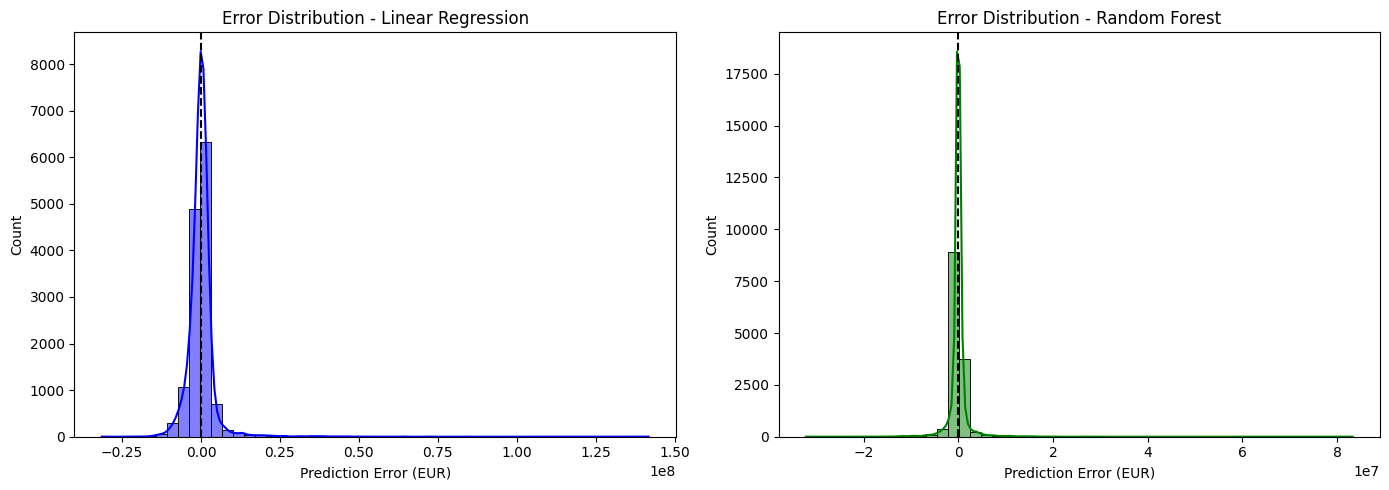

In [120]:
# Plot Error Distributions
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(y_test - y_pred_lr, kde=True, bins=50, color='blue')
plt.title("Error Distribution - Linear Regression")
plt.xlabel("Prediction Error (EUR)")
plt.axvline(0, color='black', linestyle='--')

plt.subplot(1, 2, 2)
sns.histplot(y_test - y_pred_rf, kde=True, bins=50, color='green')
plt.title("Error Distribution - Random Forest")
plt.xlabel("Prediction Error (EUR)")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

**Linear Regression:**
- The error distribution is **wide and asymmetric**, with a noticeable right skew (indicating underestimation).
- Some **large outliers on the positive side** → the model significantly **underpredicts the value of expensive players.**
- The **long right tail** shows poor accuracy for high-value players.

**Random Forest:**
- The error distribution is **more concentrated around 0** and **nearly symmetrical.**
- The **sharp, narrow peak** indicates that most predictions are close to the actual values.
- **Fewer outliers** → the model is more **stable and reliable**, regardless of player value.

✅ **Conclusion:**
- **Random Forest clearly outperforms Linear Regression** in terms of both accuracy and stability.
- While Linear Regression is sensitive to outliers (especially high-value players), **Random Forest handles non-linear patterns more effectively.**
- This demonstrates that **Linear Regression is not suitable for player value prediction**, whereas **Random Forest is a more reliable model for predicting** value_eur.

<ipython-input-121-d2aa7001c762>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")


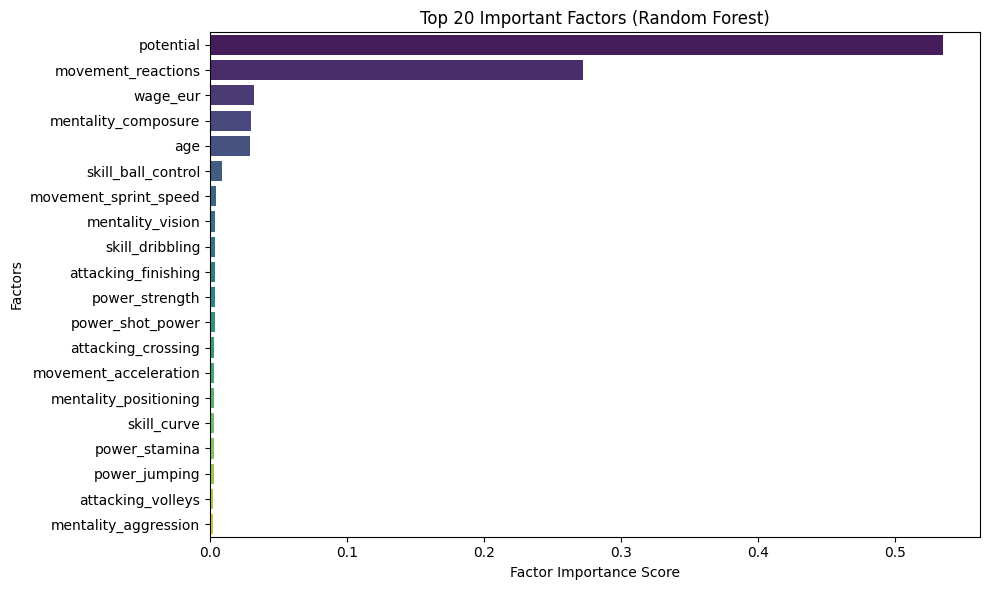

In [121]:
# Factor Importance from Random Forest
feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns)\
             .sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")
plt.title("Top 20 Important Factors (Random Forest)")
plt.xlabel("Factor Importance Score")
plt.ylabel("Factors")
plt.tight_layout()
plt.show()

**Factor Importance Analysis (Top 20 Factors):**

The chart illustrates the impact of input features on player value, as evaluated by the Random Forest model. The results reveal several key insights:
- **Potential** is the most influential feature, accounting for over 50% of the total importance. This highlights the crucial role of future development in determining a player's market value, especially for younger talents.
- **Movement Reactions** ranks second, indicating how quickly a player responds to in-game situations. This metric encapsulates real-time performance and is often associated with players who are consistent and impactful during matches.
- **Wage (EUR)**, a clear financial indicator, reflects the relationship between a player's salary and market value. Players with higher wages often hold key roles within the squad and command higher transfer values.
- Features related to **mentality and age** also demonstrate notable influence:
 - Variables such as **Mentality Composure** (calmness) and **Age** capture maturity and professional experience — both of which contribute to a player’s overall stability and market perception.
 - In contrast, **technical skills** such as ball control, sprint speed, and dribbling, while still relevant, carry lower importance weights compared to long-term strategic indicators.

**Overall Insight**
> **Strategic and long-term factors (e.g., potential, reactions, wage, age) outweigh pure technical abilities** in determining player value. This reflects a broader market perspective that emphasizes future value and consistency over short-term technical performance.

**Conclusion**

**A player's market value is not solely based on current skill levels but is significantly shaped by their growth potential, tactical responsiveness, wage level, and accumulated experience. This suggests that clubs and transfer markets assess players holistically, giving priority to attributes that reflect long-term investment and strategic value.**

### **Is a player overrated or underrated?**

In [122]:
X.columns

Index(['potential', 'wage_eur', 'age', 'height_cm', 'weight_kg', 'weak_foot',
       'skill_moves', 'international_reputation', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'africa', 'a

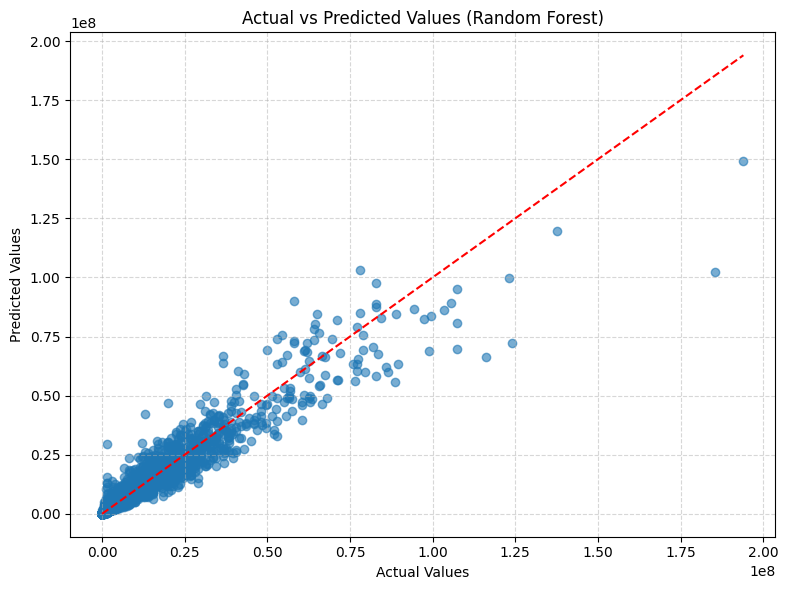

In [123]:
# Draw scatter plot to evaluate RF model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- The points distributed close to the diagonal indicate that the Random Forest model learns the relationship between the features and the player value quite effectively.
- Compared to Linear Regression – which produces larger systematic errors and is difficult to capture nonlinear relationships – RF shows **better generalization ability.**
- Although there is still an **underestimation** phenomenon with extremely high-value players (due to lack of data or special factors), the results are generally **stable and reliable**.

In [124]:
# ========== Underrated / Overrated Players ==========

# Prepare predict table
X_test_copy = X_test.copy()
X_test_copy['predicted_value'] = y_pred_rf
X_test_copy['player_id'] = X_test_copy.index

# Merge with table containing market_value_in_eur and player information
cols_to_merge = ['player_id', 'short_name', 'date_of_birth', 'club_name', 'overall',
                 'pace', 'shooting', 'dribbling', 'passing', 'defending', 'physic',
                 'position', 'nationality_name', 'value_eur', 'market_value_in_eur']

X_test_full = X_test_copy.merge(ff23_df[cols_to_merge], on='player_id', how='left')

# Eliminate players with no real market value
X_test_full = X_test_full[X_test_full['market_value_in_eur'].notna()]

# Calculate error between predicted and real value
X_test_full['error'] = X_test_full['predicted_value'] - X_test_full['market_value_in_eur']

# Filter: only keep players with error < 40,000,000
X_test_full = X_test_full[X_test_full['error'] < 40000000]

# Filter rows with sufficient information
X_test_full = X_test_full[X_test_full['short_name'].notna() & X_test_full['overall'].notna()]

# UNDERRATED: predicted > real => error > 0
underrated_df = X_test_full[X_test_full['error'] > 0]
underrated_top = underrated_df.loc[underrated_df.groupby('short_name')['error'].idxmax()]
top_underrated = underrated_top.sort_values(by='error', ascending=False).head(10)

# OVERRATED: predicted < real => error < 0
overrated_df = X_test_full[X_test_full['error'] < 0]
overrated_top = overrated_df.loc[overrated_df.groupby('short_name')['error'].idxmin()]
top_overrated = overrated_top.sort_values(by='error').head(10)

# Display result
print("TOP 10 OVERRATED Players (Model value > Market value):")
display(top_underrated[[
    'short_name', 'date_of_birth', 'nationality_name', 'club_name', 'position', 'overall',
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    'predicted_value', 'market_value_in_eur', 'error'
]])

print("TOP 10 UNDERRATED Players (Model value < Market value):")
display(top_overrated[[
    'short_name', 'date_of_birth', 'nationality_name', 'club_name', 'position', 'overall',
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    'predicted_value', 'market_value_in_eur', 'error'
]])

TOP 10 OVERRATED Players (Model value > Market value):


,short_name,date_of_birth,nationality_name,club_name,position,overall,pace,shooting,passing,dribbling,defending,physic,predicted_value,market_value_in_eur,error
3870,E. Adebayor,1984-02-26,Togo,İstanbul Başakşehir FK,Attack,79.0,69.0,76.0,66.0,71.0,32.0,73.0,37805000.0,775000.0,37030000.0
7371,M. Brown,1981-02-28,Scotland,Ross County FC,Goalkeeper,58.0,77.0,35.0,54.5,62.0,66.5,78.5,23990000.0,225000.0,23765000.0
6637,C. Gordon,1982-12-31,Scotland,Hearts,Goalkeeper,74.0,77.0,35.0,54.5,62.0,66.5,78.5,23997000.0,300000.0,23697000.0
3789,J. Van Damme,1983-10-10,Belgium,Royal Antwerp FC,Defender,71.0,62.0,60.0,67.0,61.0,73.0,86.0,18280000.0,250000.0,18030000.0
7087,E. Belözoğlu,1980-09-07,Turkey,İstanbul Başakşehir FK,Midfield,79.0,45.0,72.0,85.0,78.0,63.0,69.0,16130000.0,387500.0,15742500.0
4662,T. Manfredini,1980-05-27,Italy,Vicenza,Defender,74.0,53.0,33.0,47.0,53.0,78.0,67.0,14589000.0,50000.0,14539000.0
13034,G. O'Neil,1983-05-18,England,Bristol City,Midfield,69.0,52.0,64.0,70.0,68.0,63.0,70.0,10344000.0,500000.0,9844000.0
6760,F. Malouda,1980-06-13,France,FC Metz,Attack,77.0,70.0,76.0,76.0,80.0,30.0,72.0,9951000.0,750000.0,9201000.0
8746,N. Rafael,1984-01-10,Angola,VfL Bochum 1848,Attack,67.0,64.0,64.0,59.0,68.0,50.0,69.0,7671000.0,250000.0,7421000.0
1576,G. Greer,1980-12-14,Scotland,Kilmarnock,Defender,67.0,30.0,28.0,53.0,49.0,67.0,63.0,7329000.0,200000.0,7129000.0


TOP 10 UNDERRATED Players (Model value < Market value):


,short_name,date_of_birth,nationality_name,club_name,position,overall,pace,shooting,passing,dribbling,defending,physic,predicted_value,market_value_in_eur,error
4981,T. Huddlestone,1986-12-28,England,Hull City,Midfield,75.0,46.0,70.0,81.0,67.0,72.0,73.0,2766000.0,6000000.0,-3234000.0
11646,H. Westermann,1983-08-14,Germany,Hamburger SV,Defender,75.0,67.0,54.0,65.0,57.0,76.0,78.0,353650.0,1625000.0,-1271350.0
678,M. Bodmer,1982-11-22,France,OGC Nice,Midfield,74.0,57.0,64.0,69.0,63.0,75.0,78.0,454100.0,1500000.0,-1045900.0
11656,B. Myhill,1982-11-09,Wales,West Bromwich Albion,Goalkeeper,72.0,77.0,35.0,54.5,62.0,66.5,78.5,1081500.0,2000000.0,-918500.0
3658,L. Wilkshire,1981-10-02,Australia,Feyenoord,Defender,71.0,70.0,61.0,65.0,63.0,68.0,73.0,591750.0,1500000.0,-908250.0
6596,Rúben Fernandes,1986-05-06,Portugal,Estoril Praia,Defender,73.0,70.0,47.0,55.0,55.0,74.0,73.0,1115000.0,2000000.0,-885000.0
6712,A. Gilardino,1982-07-05,Italy,Palermo,Attack,74.0,62.0,73.0,61.0,70.0,29.0,66.0,119600.0,1000000.0,-880400.0
7641,J. Collins,1983-08-23,Wales,West Ham United,Defender,74.0,42.0,48.0,53.0,45.0,73.0,78.0,1250150.0,2000000.0,-749850.0
10298,S. Kehl,1980-02-13,Germany,Borussia Dortmund,Midfield,78.0,49.0,62.0,69.0,66.0,79.0,76.0,314750.0,1000000.0,-685250.0
8310,G. Holt,1981-04-12,England,Wigan Athletic,Attack,69.0,37.0,73.0,63.0,62.0,46.0,79.0,489600.0,750000.0,-260400.0


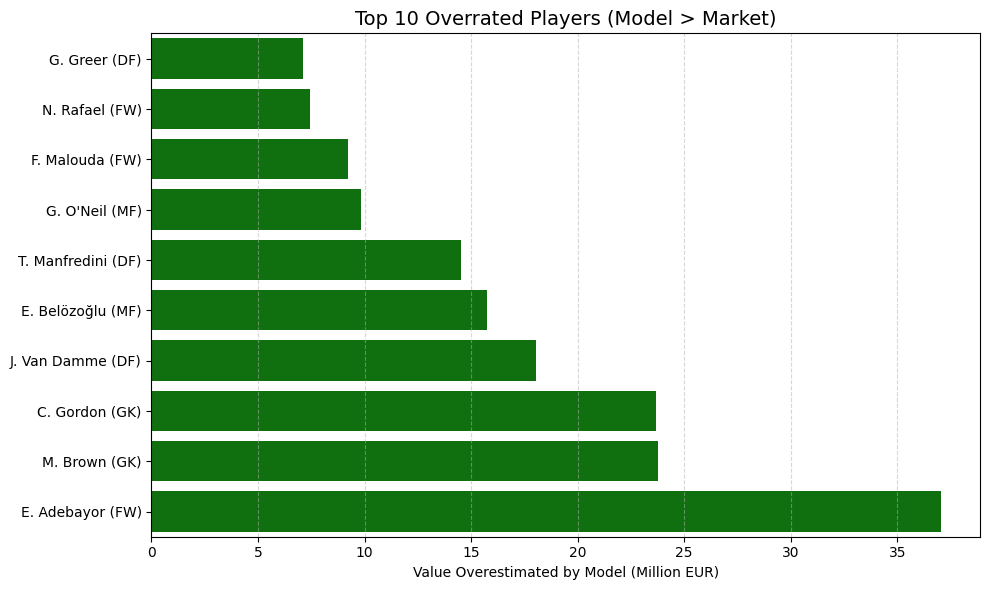

In [125]:
# Prepare data
underrated_plot = top_underrated.sort_values(by='error', ascending=True).copy()
underrated_plot['error_million'] = underrated_plot['error'] / 1e6

# Add position info into player name
underrated_plot = underrated_plot.merge(ff23_df[['player_id', 'position_group']], on='player_id', how='left')
underrated_plot['name_position'] = underrated_plot['short_name'] + ' (' + underrated_plot['position_group'] + ')'

# Draw chart
plt.figure(figsize=(10, 6))
sns.barplot(data=underrated_plot, x='error_million', y='name_position', color='green')

plt.title("Top 10 Overrated Players (Model > Market)", fontsize=14)
plt.xlabel("Value Overestimated by Model (Million EUR)")
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

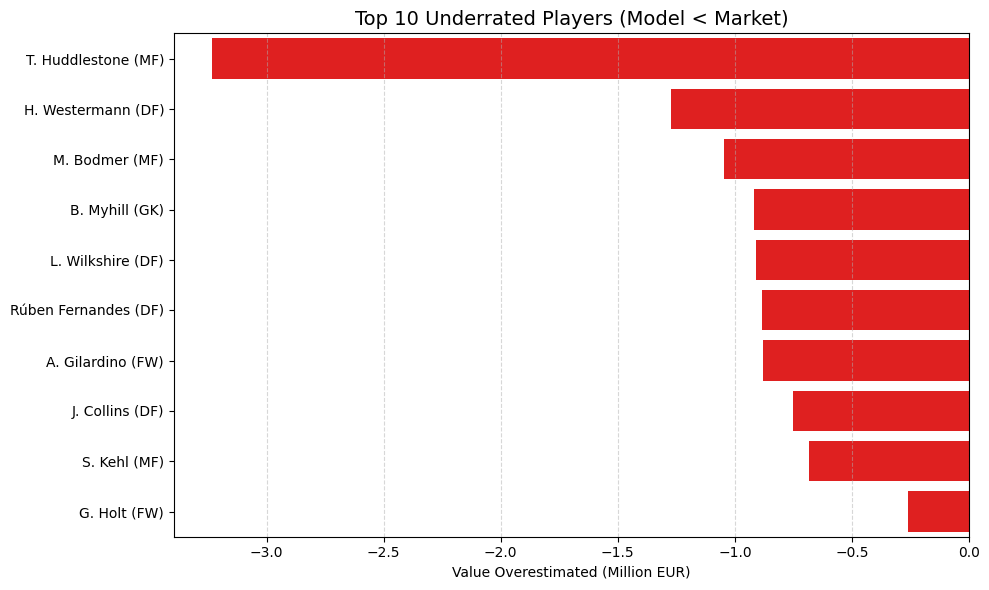

In [126]:
# Prepare data
overrated_plot = top_overrated.sort_values(by='error', ascending=True).copy()
overrated_plot['error_million'] = overrated_plot['error'] / 1e6

# Add position info into player name
overrated_plot = overrated_plot.merge(ff23_df[['player_id', 'position_group']], on='player_id', how='left')
overrated_plot['name_position'] = overrated_plot['short_name'] + ' (' + overrated_plot['position_group'] + ')'

# Draw chart
plt.figure(figsize=(10, 6))
sns.barplot(data=overrated_plot, x='error_million', y='name_position', color='red')

plt.title("Top 10 Underrated Players (Model < Market)", fontsize=14)
plt.xlabel("Value Overestimated (Million EUR)")
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Analysis of Overrated & Underrated Players**

The chart highlights top 10 players whose market values are either significantly higher (overrated) or lower (underrated) than their predicted values based on a Random Forest valuation model.

**Key Insights:**

**🟩 Underrated Players – Smart Transfer Opportunities**

Underrated players have predicted values that are significantly higher than their current market prices. This presents an excellent opportunity for clubs to acquire talents **at a lower cost than their true worth**, making it especially valuable for clubs with limited budgets or long-term investment strategies.
Such players often share one or more of the following characteristics:
- **High development potential** that has not yet been fully realized.
- **Outstanding performance** that exceeds expectations but has not garnered media attention.
- Playing for **smaller clubs**, which may lead to underappreciation in the market.
> **Practical Application:** Clubs can use this insight to identify **hidden gems**, secure undervalued signings, and optimize transfer spending — gaining both **competitive edge on the pitch** and **financial efficiency** off it.

**🟥 Overrated Players – Investment Risks**

In contrast, overrated players have market values that **exceed their predicted worth**, suggesting they may be **overhyped by media, inconsistent in performance, pursued by multiple clubs, or paid excessively relative to their actual impact.**
> **Practical Application:** Early identification of overrated players allows clubs to **avoid risky or overpriced transfers, negotiate more realistic transfer fees** for targets, and **reevaluate salary structures** or **transfer decisions** based on true value rather than perception.

**Conclusion:**
The Overrated – Underrated analysis is not just a data exercise — it's a **strategic tool** in scouting, recruitment, and transfer planning. By leveraging data-driven valuation models, clubs can:
- Identify **high-potential transfer targets** at fair or bargain prices.
- Minimize **financial risks** associated with overpaying.
- Optimize **human resource investment** based on objective performance indicators rather than subjective bias or media influence.

**📌 Recommendations for Clubs & Transfer Analysts:**
- **Integrate Predictive Valuation into Scouting Pipelines**
Use machine learning-based valuation as a standard filter when evaluating new player targets. This enables **early identification of undervalued talent and helps prioritize recruitment efforts.**
- **Build a "Watchlist" of Underrated Players**
Maintain a dynamic list of players flagged by the model as underrated. These could be **ideal transfer targets** for clubs with long-term planning, youth development focus, or financial limitations.
- **Avoid Overpaying Through Objective Benchmarks**
Before finalizing high-profile signings, use predicted valuations to **benchmark against hype-driven market prices**, minimizing the risk of signing **overpriced or underperforming players.**
- **Strengthen Negotiation Leverage**
Data-backed insights on overvaluation can be a **powerful negotiation tool**, helping clubs argue for lower transfer fees or structured payment plans based on actual performance.
- **Combine Model Output with Human Expertise**
While predictive models offer quantitative power, they should **complement, not replace**, the work of scouts and analysts. A hybrid approach—balancing data with tactical fit, attitude, and injury history—yields the best decisions.
> ⚽ **Final Thought:**
In an era where **transfer decisions can define a club's future**, embracing data-driven valuation isn't just a competitive advantage — it's a **necessity for modern football success.**